
DixonPrice:

GP EI: zero versus exact partial-order GP EI derivatives wrt **x1**, **x2**, **x3**, **x4**

In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=3d2be120235a9d60160b1f2dd14bdc7cf0ac2a86e87ab26d51d6cecc59ae8ede
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
n_start_AcqFunc = 100 #multi-start iterations to avoid local optima in AcqFunc optimization


In [4]:
### Inputs:

func = 'DixonPrice'
n_test = 500
eps = 1e-08

util_grad_zero = 'dEI_GP'
util_grad_exact = 'dEI_GP'

n_init = 5 # random initialisations
iters = 40
opt = True

In [5]:
### Objective Function - Dixon-Price(x) 4-D:

def objfunc(x1_training, x2_training, x3_training, x4_training):
            return  operator * ((x1_training - 1)**2
                            + 2 * (2 * x2_training ** 2 - x1_training)**2
                            + 3 * (2 * x3_training ** 2 - x2_training)**2
                            + 4 * (2 * x4_training ** 2 - x3_training)**2            
                           )

        
# Constraints:
lb = -10
ub = +10
    
# Input array dimension(s):
dim = 4

# 4-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub]),
                 'x3_training': ('cont', [lb, ub]),
                 'x4_training': ('cont', [lb, ub])}
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x3_test = np.linspace(lb, ub, n_test)
x4_test = np.linspace(lb, ub, n_test)
Xstar = np.column_stack((x1_test, x2_test, x3_test, x4_test))

Xstar_d = np.column_stack((x1_test, x2_test, x3_test))
    

In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(-dKstar, self.alpha)
        ds = -2 * np.dot(-dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO_zero:

zero_grad = 0

class dGPGO_zero(GPGO):  
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * zero_grad

    def acqfunc_h(self, xnew, n_start=n_start_AcqFunc, eps=eps):
        f = self.acqfunc(xnew)[0]
        
        new_mean_h, new_var_h = self.GP.predict(xnew + eps, return_std=True)
        new_std_h = np.sqrt(new_var_h + eps)
        dm_h, ds_h = self.GP.AcqGrad(xnew + eps)
        f_h = self.A.d_eval(-self.tau, new_mean_h, new_std_h, ds=ds_h, dm=dm_h)[0]
        
        exact_grad = (-f_h - f)/eps
        return exact_grad


In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad

    def acqfunc_h(self, xnew, n_start=n_start_AcqFunc, eps=eps):
        f = self.acqfunc(xnew)[0]
        
        new_mean_h, new_var_h = self.GP.predict(xnew + eps, return_std=True)
        new_std_h = np.sqrt(new_var_h + eps)
        dm_h, ds_h = self.GP.AcqGrad(xnew + eps)
        f_h = self.A.d_eval(-self.tau, new_mean_h, new_std_h, ds=ds_h, dm=dm_h)[0]
        
        exact_grad = (-f_h - f)/eps
        return exact_grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_exact = time.time()
start_exact


1629298876.258907

In [13]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65955991  4.40648987 -9.9977125  -3.95334855]. 	  -124757.8119225052 	 -3468.30836846115
init   	 [-7.06488218 -8.1532281  -6.27479577 -3.08878546]. 	  -64499.71723544843 	 -3468.30836846115
init   	 [-2.06465052  0.77633468 -1.61610971  3.70439001]. 	  -3468.30836846115 	 -3468.30836846115
init   	 [-5.91095501  7.56234873 -9.45224814  3.4093502 ]. 	  -121117.80061324051 	 -3468.30836846115
init   	 [-1.65390395  1.17379657 -7.19226123 -6.03797022]. 	  -57099.80140311415 	 -3468.30836846115
1      	 [-3.68968738  3.73001855  6.69251344 -9.63423445]. 	  -152203.3072503334 	 -3468.30836846115
2      	 [-6.24736654  2.44991805  8.11618992  9.79910357]. 	  -186189.50316819487 	 -3468.30836846115
3      	 [ 5.02242081  1.58721081  8.49408363 -8.70520033]. 	  -142988.67015156813 	 -3468.30836846115
4      	 [10.         10.         10.          6.79795509]. 	  -207756.11817747718 	 -3468.30836846115
5      	 [ 5.97945681

In [14]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.28010196 -9.48147536  0.99324956 -1.29355215]. 	  -65998.62492491212 	 -5357.298687487265
init   	 [-1.59264396 -3.39330358 -5.90702732  2.38541933]. 	  -18480.208513614372 	 -5357.298687487265
init   	 [-4.00690653 -4.6634545   2.42267666  0.58284189]. 	  -5357.298687487265 	 -5357.298687487265
init   	 [-7.30840109  0.27156243 -6.31120269  5.70670296]. 	  -39506.050198776116 	 -5357.298687487265
init   	 [ 7.07950585 -0.11526325  6.93122971 -8.40709046]. 	  -100181.87164248743 	 -5357.298687487265
1      	 [-2.26214698  5.87274909  1.60008358 -6.75402803]. 	  -42299.564587152665 	 -5357.298687487265
2      	 [-8.77692463 -2.54457149 -1.31781306  9.47735243]. 	  -132131.8483847979 	 -5357.298687487265
3      	 [ 4.62190764 -6.83721008  8.23256169 -9.96152115]. 	  -221384.11270043574 	 -5357.298687487265
4      	 [ 8.70233959  0.42166332 -8.66816053  8.53322589]. 	  -162799.86303827737 	 -5357.298687487265
5      	 

In [15]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.01595805  4.16295645 -4.18190522  0.2165521 ]. 	  -5185.478651216821 	 -5185.478651216821
init   	 [ 7.85893909  7.92586178 -7.48829379 -5.85514244]. 	  -83515.21921243734 	 -5185.478651216821
init   	 [-8.97065593 -1.18380313 -9.40247578 -0.86333551]. 	  -95899.98071510748 	 -5185.478651216821
init   	 [ 2.98288095 -4.43025435  3.52509804  1.81725635]. 	  -5245.566173274534 	 -5185.478651216821
init   	 [-9.52036235  1.17708176 -4.81495106 -1.69797606]. 	  -6987.20591009812 	 -5185.478651216821
1      	 [-4.16414452 -0.84627201  7.21067826  1.72505809]. 	  -33066.17455447326 	 -5185.478651216821
2      	 [-1.42093745 -2.38317783  4.89209527 -7.84297806]. 	  -63728.37816006544 	 -5185.478651216821
3      	 [-1.98230524 -6.0350318  -5.50491833  4.81186289]. 	  -35268.92783271308 	 -5185.478651216821
4      	 [-6.95962222 -6.12078547  1.05388197 -2.78453945]. 	  -14518.910980760065 	 -5185.478651216821
5      	 [0.638

In [16]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.34059678 0.94464498 9.4536872  4.29631987]. 	  -98038.88529472692 	 -30605.91051461647
init   	 [ 3.95457649 -5.67821009  9.5254891  -9.8753949 ]. 	  -250082.3135303139 	 -30605.91051461647
init   	 [-4.94035275 -1.30416935  5.58765844 -6.04629851]. 	  -30605.91051461647 	 -30605.91051461647
init   	 [ 7.25986471  9.66801354 -6.72315517  1.94667888]. 	  -84981.75728489687 	 -30605.91051461647
init   	 [-9.82027805 -2.26857435 -9.11679884  9.13305935]. 	  -209926.3636588899 	 -30605.91051461647
1      	 [ 0.90405303  0.4880816   2.75220488 -1.97009113]. 	  -745.6386114710477 	 -745.6386114710477
2      	 [ 5.30486793 -6.47973031  3.69857697  5.99163089]. 	  -34382.12799826672 	 -745.6386114710477
3      	 [ 2.4466868   7.07389918 -9.38608835  0.44996754]. 	  -105258.29989725006 	 -745.6386114710477
4      	 [ 4.73707556 -0.72479098 -9.3121442  -0.43521843]. 	  -91408.63072502242 	 -745.6386114710477
5      	 [-7.88752

In [17]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.56013658  7.41464612 -5.86561689  8.37221816]. 	  -123365.27648936227 	 -3383.131100651736
init   	 [-0.23177622  2.23487726  5.31815713  0.36835976]. 	  -9167.819359373088 	 -3383.131100651736
init   	 [-4.06398997 -6.24557543 -8.38517462  4.76880592]. 	  -89817.03050330501 	 -3383.131100651736
init   	 [-1.17381554 -6.83380265  7.59874062 -4.51827076]. 	  -67194.19259941578 	 -3383.131100651736
init   	 [-1.71529962 -4.07840135  2.57575818  1.5967562 ]. 	  -3383.131100651736 	 -3383.131100651736
1      	 [ 1.55325716 -9.96715655  0.30945224  2.79590352]. 	  -78973.83235307777 	 -3383.131100651736
2      	 [ 4.5613969  -4.67352895  0.23379911  2.52038149]. 	  -3764.5149974571405 	 -3383.131100651736
3      	 [-2.15134925  9.53418759  4.82671391  6.46019907]. 	  -96545.59507289826 	 -3383.131100651736
4      	 [ 4.17941015  0.37676612 -9.58435076 -5.8403882 ]. 	  -125098.43308590596 	 -3383.131100651736
5      	 [-4

In [18]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.85720303 -3.36040389  6.42458246 -9.16606749]. 	  -127092.75617551396 	 -624.5256755977402
init   	 [-7.8468664   1.90104128  0.59634724 -1.62385143]. 	  -624.5256755977402 	 -624.5256755977402
init   	 [-3.29184301  2.45038864 -1.23717148  4.71764213]. 	  -8859.81358392905 	 -624.5256755977402
init   	 [0.36072824 1.577172   2.90710192 9.80448543]. 	  -144159.4084820958 	 -624.5256755977402
init   	 [ 6.39716394 -1.7359813   7.5253531   6.47518865]. 	  -63008.48019540512 	 -624.5256755977402
1      	 [ 4.34664291  8.74699069 -2.96380463 -4.92731805]. 	  -55069.53937594843 	 -624.5256755977402
2      	 [-5.57681425  2.83874787  4.53696953  0.08226863]. 	  -5473.778851701596 	 -624.5256755977402
3      	 [ 8.56608527  1.00066366 -5.6557535   4.78400723]. 	  -22620.59205919053 	 -624.5256755977402
4      	 [-3.88060276 -3.60562409  2.63626196 -8.23698378]. 	  -73548.32801665392 	 -624.5256755977402
5      	 [10. 10. 1

In [19]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.47383421  5.59837584 -1.23181537  4.46930356]. 	  -17019.79107531184 	 -17019.79107531184
init   	 [ 9.55979024  0.76991741  0.02240927 -8.55897733]. 	  -86052.31833948194 	 -17019.79107531184
init   	 [-4.63122040e+00 -2.34998349e-03  3.58459992e+00  6.07478072e+00]. 	  -21780.37729666353 	 -17019.79107531184
init   	 [-2.38117734 -8.68127306 -4.23708801  8.19187055]. 	  -129535.16295638582 	 -17019.79107531184
init   	 [-5.73229293 -0.95752076  8.62412039 -9.50201545]. 	  -185668.2647263406 	 -17019.79107531184
1      	 [ 6.75835989  5.37295013 -3.72010646  1.45250665]. 	  -6975.589978136528 	 -6975.589978136528
2      	 [-2.26867274 -4.96775263 -3.10681926 -5.91972827]. 	  -28537.54981454135 	 -6975.589978136528
3      	 [-7.16204884  2.23165949  9.48914499 -4.53159477]. 	  -99540.9307690916 	 -6975.589978136528
4      	 [ 4.29877809  2.09137364 -5.85501544 -4.79573932]. 	  -24060.70100027514 	 -6975.589978136528

In [20]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.46858806 9.37081326 7.3838908  0.61711383]. 	  -86573.97855073148 	 -25.893516297744075
init   	 [-5.34543344 -9.77202391 -1.39062363 -1.9529728 ]. 	  -78014.94707602388 	 -25.893516297744075
init   	 [ 0.45349343 -0.43216408  1.10712948  0.86772035]. 	  -25.893516297744075 	 -25.893516297744075
init   	 [ 5.21791151  4.24749148  2.39364192 -1.47816459]. 	  -2094.6625710702797 	 -25.893516297744075
init   	 [-4.21849944  9.47710482 -3.32451909 -5.62397878]. 	  -85839.98682911636 	 -25.893516297744075
1      	 [-3.60620407 -1.35048134 -4.59708517  6.02111773]. 	  -29614.34759252149 	 -25.893516297744075
2      	 [7.02116965 7.81234303 5.75333375 8.88043753]. 	  -129115.30708808656 	 -25.893516297744075
3      	 [ 2.38733468 -2.49139217 -6.58364982  0.33931039]. 	  -24248.081279433543 	 -25.893516297744075
4      	 [ 7.56352013 -7.67982822 -8.37749723  2.84161744]. 	  -92575.686823112 	 -25.893516297744075
5      	 [-5

In [21]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-9.79251692  0.03749184 -0.08453414 -7.32340942]. 	  -46403.767220916365 	 -4516.871493114117
init   	 [-7.15777829 -5.62882649 -1.62983639 -5.03797663]. 	  -21353.090000074142 	 -4516.871493114117
init   	 [-8.31880698 -3.0900272  -6.66447307  7.57118171]. 	  -85802.65922587285 	 -4516.871493114117
init   	 [ 9.01928063 -9.22503248  3.98214783  1.45519631]. 	  -57052.85171456846 	 -4516.871493114117
init   	 [7.96014236 3.33797946 0.95675566 4.04854848]. 	  -4516.871493114117 	 -4516.871493114117
1      	 [ 7.46801686  8.12554554  5.16555974 -3.06196092]. 	  -37961.04796864094 	 -4516.871493114117
2      	 [ 1.79155607  6.63416988 -1.83334365 -8.8517705 ]. 	  -115413.89052074494 	 -4516.871493114117
3      	 [ 9.33019641 -7.52767745 -5.63058289 -0.50920484]. 	  -36948.48564229587 	 -4516.871493114117
4      	 [ 9.24871681 -5.28271506  6.79982967  9.30415074]. 	  -143743.462714014 	 -4516.871493114117
5      	 [-3.7962

In [22]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.42641287 -9.58496101  2.6729647   4.97607765]. 	  -74102.72845843069 	 -18605.704548112226
init   	 [-0.02985975 -5.50406709 -6.0387427   5.21061424]. 	  -40371.05435055173 	 -18605.704548112226
init   	 [-6.61778327 -8.23320372  3.70719637  9.06786692]. 	  -147677.31829065934 	 -18605.704548112226
init   	 [-9.92103467  0.24384527  6.25241923  2.25052134]. 	  -18605.704548112226 	 -18605.704548112226
init   	 [ 4.43510635 -4.16247864  8.35548245  4.29151567]. 	  -67109.3842877247 	 -18605.704548112226
1      	 [-3.98599887 -7.72031276  6.57362653 -9.06207361]. 	  -156405.43057273046 	 -18605.704548112226
2      	 [ 5.24133604  6.79774962 -7.90085176  0.21262617]. 	  -57280.06880918705 	 -18605.704548112226
3      	 [-6.98285725 -7.53553636 -0.44064091 -4.85155595]. 	  -38348.42146299815 	 -18605.704548112226
4      	 [-1.78826799  3.25598727 -1.45510672  1.58046094]. 	  -1234.2884190825898 	 -1234.2884190825898
5  

In [23]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.39460622 -9.61049517 -0.73562947  4.49867858]. 	  -80243.41172762495 	 -39961.870979084335
init   	 [-1.59592791 -0.29145804 -9.74438371 -0.25256785]. 	  -108928.04860600414 	 -39961.870979084335
init   	 [ 8.83613305  7.01590179  4.5992894  -7.82527856]. 	  -75431.53172537561 	 -39961.870979084335
init   	 [ 7.87808341  7.14308494 -6.69826765  2.64668028]. 	  -39961.870979084335 	 -39961.870979084335
init   	 [-9.59032774 -7.66525462 -3.67265377 -6.84175387]. 	  -73885.31196002741 	 -39961.870979084335
1      	 [ 8.98204795  9.73346661 -3.23891901 -5.20250642]. 	  -78768.56237678342 	 -39961.870979084335
2      	 [-2.46813997 -7.30037789 -2.91425155  2.82909319]. 	  -27001.41564071569 	 -27001.41564071569
3      	 [-2.7011834   8.03388106 -4.64351945  0.87154575]. 	  -38595.660189414666 	 -27001.41564071569
4      	 [ 8.76589534 -3.7692322   0.38597262 -4.05301551]. 	  -5098.7058724192575 	 -5098.7058724192575
5   

In [24]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.91674315  4.80099393 -4.7336997   0.67478787]. 	  -10615.027220241049 	 -10615.027220241049
init   	 [-9.70850075  8.37494016  8.01429708 -9.33157145]. 	  -198779.9445700966 	 -10615.027220241049
init   	 [ 9.13898673 -7.25581357 -4.32343294  2.12166369]. 	  -25246.229651049434 	 -10615.027220241049
init   	 [ 8.88450272  7.05471082 -9.95481533  0.42452054]. 	  -126529.63212628796 	 -10615.027220241049
init   	 [ 1.04075267 -0.29245173  5.36268308 -6.78566494]. 	  -40114.0772599786 	 -10615.027220241049
1      	 [ 9.00627049  5.34951301  6.50018506 -1.86719396]. 	  -23513.617348450025 	 -10615.027220241049
2      	 [ 8.88428387 -2.74934901 -7.2021893  -8.7943139 ]. 	  -138985.0382288978 	 -10615.027220241049
3      	 [7.07957877 4.20923579 8.31123577 5.90287485]. 	  -70536.44119328947 	 -10615.027220241049
4      	 [ 3.65158786 -4.292633    3.33049006  6.75429274]. 	  -35227.82899489502 	 -10615.027220241049
5      

In [25]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.55404821 -5.2491756   6.48557065  9.31498396]. 	  -140521.09097301037 	 -14230.664746472014
init   	 [ 9.45202228 -0.93101505  2.18084926  5.51053029]. 	  -14230.664746472014 	 -14230.664746472014
init   	 [ 2.8322669   4.44036459 -9.29926952 -4.03101058]. 	  -94860.11143837457 	 -14230.664746472014
init   	 [-8.82975016  7.14121885 -2.54291944  3.59695903]. 	  -27991.658975969378 	 -14230.664746472014
init   	 [-4.87440101 -3.0483757  -9.8117446  -2.83332435]. 	  -118576.87858321254 	 -14230.664746472014
1      	 [ 9.1114829  -9.99975933 -5.06042598  4.24465356]. 	  -90932.40249777345 	 -14230.664746472014
2      	 [-9.72135464 -7.69244795 -6.22844507  7.60723681]. 	  -114241.30485743654 	 -14230.664746472014
3      	 [-8.34192966  0.2136618  -9.02437946 -5.92937228]. 	  -104788.29228738562 	 -14230.664746472014
4      	 [ 0.57275335 -7.71738011 -5.09743991 -0.17013756]. 	  -38898.41073512287 	 -14230.664746472014


In [26]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.27886688  5.46330104  7.40855371 -9.83906103]. 	  -178393.1355710015 	 -18811.845771320182
init   	 [-3.80528149  9.15207479  0.26233425 -3.6343115 ]. 	  -61708.37227853236 	 -18811.845771320182
init   	 [ 0.78399875 -5.57490115  6.12962716 -3.15490749]. 	  -27840.032280292544 	 -18811.845771320182
init   	 [ 0.77777698 -9.88252429  3.46304956 -5.79951476]. 	  -95425.8534148436 	 -18811.845771320182
init   	 [ 8.65115186 -2.51510501  5.04837844  5.26278004]. 	  -18811.845771320182 	 -18811.845771320182
1      	 [-6.20242914 -2.96747056  4.29623333 -2.85129273]. 	  -6530.500693022571 	 -6530.500693022571
2      	 [ 3.07044426 -6.31045846  1.63194229  8.38251886]. 	  -89311.7774639001 	 -6530.500693022571
3      	 [2.67305604 5.51907321 6.71543751 9.91762785]. 	  -172702.85853204515 	 -6530.500693022571
4      	 [0.19437843 2.05845053 1.65792191 5.18484457]. 	  -11033.931856338317 	 -6530.500693022571
5      	 [-1.318

In [27]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.97635395 -6.4220815  -8.91273571 -2.76923108]. 	  -95759.56429474254 	 -7452.834860002497
init   	 [-4.49198143  0.6000045  -3.88162169 -3.91051282]. 	  -7452.834860002497 	 -7452.834860002497
init   	 [-7.76517448 -5.00201972  8.35259796 -4.71706293]. 	  -74656.79367914848 	 -7452.834860002497
init   	 [ 4.35547375  7.31430068  6.14158964 -5.78898835]. 	  -49831.894800532486 	 -7452.834860002497
init   	 [-6.65513937 -9.06587217 -9.21155376 -5.9953838 ]. 	  -180751.6072602438 	 -7452.834860002497
1      	 [ 3.91355621 -9.41682078 -0.01015161 -7.34731365]. 	  -107072.45825519481 	 -7452.834860002497
2      	 [4.92526955 5.96067446 4.10838652 1.54460964]. 	  -11082.60249594799 	 -7452.834860002497
3      	 [ 7.60284646 -9.83670929  6.07418637  6.51677002]. 	  -115033.36967489062 	 -7452.834860002497
4      	 [-3.39221728 -3.69203211  3.60318038  4.66933918]. 	  -10938.171069717677 	 -7452.834860002497
5      	 [ 9.63

In [28]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.53417842  0.46326683  1.01402913 -9.087961  ]. 	  -107926.01810012864 	 -13215.254483149873
init   	 [-2.78542329 -5.53838117  3.77452324 -6.7253715 ]. 	  -41773.31935362981 	 -13215.254483149873
init   	 [-8.59350266  8.8202172   1.2736276  -8.44015321]. 	  -133847.71429861046 	 -13215.254483149873
init   	 [ 4.45281022 -6.83095653 -4.99437387 -4.13025488]. 	  -31578.153521275904 	 -13215.254483149873
init   	 [ 3.93221428 -0.71471824 -5.69875713 -1.06347476]. 	  -13215.254483149873 	 -13215.254483149873
1      	 [-0.64007705  3.2211867   3.79933264 -4.73341031]. 	  -9619.115103084405 	 -9619.115103084405
2      	 [ 5.98502725 -7.94806028 -2.90882686  9.11344119]. 	  -145121.67362164083 	 -9619.115103084405
3      	 [ 0.47384394 -7.09622115 -6.44235327  3.14296454]. 	  -47197.66759876199 	 -9619.115103084405
4      	 [ 5.52616367  4.65190076  3.38866017 -9.07435877]. 	  -107947.34227207064 	 -9619.115103084405
5   

In [29]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.10669995  0.61173511 -6.16958426 -8.64199284]. 	  -113948.99393259197 	 -849.5238302802878
init   	 [5.7397092  3.12667044 2.75041792 1.51205788]. 	  -849.5238302802878 	 -849.5238302802878
init   	 [-9.21874168 -2.84372791  8.91366374 -8.79910639]. 	  -165071.6247490734 	 -849.5238302802878
init   	 [ 7.28084207  7.54581052 -8.97612669  3.04837231]. 	  -96579.16352863169 	 -849.5238302802878
init   	 [ 1.03502737  1.95026506 -0.32942751 -4.34023678]. 	  -5872.837304694351 	 -849.5238302802878
1      	 [-6.82082511  3.53524771 -7.6305547  -1.10007868]. 	  -40739.58096344288 	 -849.5238302802878
2      	 [ 6.36132887 -5.79483735 -1.80465394 -5.23795116]. 	  -20725.35045584762 	 -849.5238302802878
3      	 [-9.93358214e+00  6.76426027e-04 -8.86041968e-01 -1.86772363e+00]. 	  -571.5810915631586 	 -571.5810915631586
4      	 [-3.57261465 -5.71224609 -1.88427713  4.42421021]. 	  -16723.521728434527 	 -571.5810915631586
5

In [30]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.00748483  0.10906747  7.57202942 -6.36319549]. 	  -60950.54433734527 	 -35863.1928389845
init   	 [7.04466137 5.00272572 3.32203335 9.75790897]. 	  -144653.21215567738 	 -35863.1928389845
init   	 [-4.86063155 -9.43388149  2.71438231  6.94624775]. 	  -103843.63546667778 	 -35863.1928389845
init   	 [ 4.7234925  -9.58385776 -7.76793739 -4.04552516]. 	  -121548.02251070282 	 -35863.1928389845
init   	 [ 3.73940383  7.23252112 -6.02731282  3.14378061]. 	  -35863.1928389845 	 -35863.1928389845
1      	 [-6.1664519   4.28513481  2.79740714  0.66407663]. 	  -4132.892348949624 	 -4132.892348949624
2      	 [ 5.61099687  3.24280582 -9.3946128  -2.53775904]. 	  -92553.92031901842 	 -4132.892348949624
3      	 [ 3.30844591  7.22382356 -9.24562539  8.22016947]. 	  -184254.39787154962 	 -4132.892348949624
4      	 [ 8.03656335 -7.89614249  7.70734605  1.23688198]. 	  -75516.33414231456 	 -4132.892348949624
5      	 [ 9.562822  

In [31]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.04932797  5.22499433 -5.06124054 -7.23736625]. 	  -62523.95884648901 	 -4213.270400555922
init   	 [-3.37106873 -8.3400087   3.43954163  6.13187596]. 	  -64291.98059909556 	 -4213.270400555922
init   	 [ 9.65483829  2.7132147  -5.68153488  0.98054864]. 	  -11832.547728260697 	 -4213.270400555922
init   	 [ 9.11199160e-01 -5.31847854e+00 -7.72548314e+00 -6.81465902e-03]. 	  -53073.88259500524 	 -4213.270400555922
init   	 [-6.95783155  0.65372161 -2.25986463  3.76654767]. 	  -4213.270400555922 	 -4213.270400555922
1      	 [-6.5477408   0.83865275 -8.96461914  6.51115227]. 	  -112037.9546475548 	 -4213.270400555922
2      	 [-4.76936448 -2.97550534  8.89602795 -8.21242057]. 	  -142547.97738902242 	 -4213.270400555922
3      	 [-2.32173541  7.26125369  5.5769216  -4.96985133]. 	  -39978.81776250941 	 -4213.270400555922
4      	 [-9.13977787 -5.66464753  4.94279629  8.45310839]. 	  -95912.86613447932 	 -4213.2704005559

In [32]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.76261602 7.95427456 7.83061459 6.31674955]. 	  -91316.16764460134 	 -3319.2244649980007
init   	 [-9.28220829  3.83515164 -2.42638116  0.37021891]. 	  -3319.2244649980007 	 -3319.2244649980007
init   	 [ 3.15902931 -6.12299564 -4.55367196  4.37211867]. 	  -24439.65199379687 	 -3319.2244649980007
init   	 [ 5.66007219  7.0065528   5.50489788 -9.26671387]. 	  -136303.90993612286 	 -3319.2244649980007
init   	 [-7.6661253   5.02561399 -5.21563568 -4.90387972]. 	  -25528.595644187833 	 -3319.2244649980007
1      	 [-0.38031735 -3.41587185  0.21282112 -4.72742343]. 	  -9079.144305704322 	 -3319.2244649980007
2      	 [ 2.2515589  -8.62950692  7.2874785   9.15451767]. 	  -185415.98077785788 	 -3319.2244649980007
3      	 [-2.00279263 -5.09620423  0.51102349  6.68881567]. 	  -37586.207214372705 	 -3319.2244649980007
4      	 [ 0.69284317  3.15192848 -8.93401192  2.30035677]. 	  -75718.37358614859 	 -3319.2244649980007
5    

In [33]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

start_zero = time.time()
start_zero

1629304481.0038712

In [34]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_zero_1 = dGaussianProcess(cov_func, optimize=opt)

zero_1 = dGPGO_zero(surrogate_zero_1, Acquisition_new(util_grad_zero), objfunc, param)
zero_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65955991  4.40648987 -9.9977125  -3.95334855]. 	  -124757.8119225052 	 -3468.30836846115
init   	 [-7.06488218 -8.1532281  -6.27479577 -3.08878546]. 	  -64499.71723544843 	 -3468.30836846115
init   	 [-2.06465052  0.77633468 -1.61610971  3.70439001]. 	  -3468.30836846115 	 -3468.30836846115
init   	 [-5.91095501  7.56234873 -9.45224814  3.4093502 ]. 	  -121117.80061324051 	 -3468.30836846115
init   	 [-1.65390395  1.17379657 -7.19226123 -6.03797022]. 	  -57099.80140311415 	 -3468.30836846115
1      	 [-3.68968738  3.73001855  6.69251344 -9.63423445]. 	  -152203.3072503334 	 -3468.30836846115
2      	 [-6.24736654  2.44991805  8.11618992  9.79910357]. 	  -186189.50316819487 	 -3468.30836846115
3      	 [ 5.02242081  1.58721081  8.49408363 -8.70520033]. 	  -142988.67015156813 	 -3468.30836846115
4      	 [3.79278798 1.97641781 4.93314944 0.83942124]. 	  -6631.198096715654 	 -3468.30836846115
5      	 [ 8.61288784 -4.8

In [35]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_zero_2 = dGaussianProcess(cov_func, optimize=opt)

zero_2 = dGPGO_zero(surrogate_zero_2, Acquisition_new(util_grad_zero), objfunc, param)
zero_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.28010196 -9.48147536  0.99324956 -1.29355215]. 	  -65998.62492491212 	 -5357.298687487265
init   	 [-1.59264396 -3.39330358 -5.90702732  2.38541933]. 	  -18480.208513614372 	 -5357.298687487265
init   	 [-4.00690653 -4.6634545   2.42267666  0.58284189]. 	  -5357.298687487265 	 -5357.298687487265
init   	 [-7.30840109  0.27156243 -6.31120269  5.70670296]. 	  -39506.050198776116 	 -5357.298687487265
init   	 [ 7.07950585 -0.11526325  6.93122971 -8.40709046]. 	  -100181.87164248743 	 -5357.298687487265
1      	 [-2.26214698  5.87274909  1.60008358 -6.75402803]. 	  -42299.564587152665 	 -5357.298687487265
2      	 [-8.77692463 -2.54457149 -1.31781306  9.47735243]. 	  -132131.8483847979 	 -5357.298687487265
3      	 [ 4.62190764 -6.83721008  8.23256169 -9.96152115]. 	  -221384.11270043574 	 -5357.298687487265
4      	 [ 8.70233959  0.42166332 -8.66816053  8.53322589]. 	  -162799.86303827737 	 -5357.298687487265
5      	 

In [36]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_zero_3 = dGaussianProcess(cov_func, optimize=opt)

zero_3 = dGPGO_zero(surrogate_zero_3, Acquisition_new(util_grad_zero), objfunc, param)
zero_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.01595805  4.16295645 -4.18190522  0.2165521 ]. 	  -5185.478651216821 	 -5185.478651216821
init   	 [ 7.85893909  7.92586178 -7.48829379 -5.85514244]. 	  -83515.21921243734 	 -5185.478651216821
init   	 [-8.97065593 -1.18380313 -9.40247578 -0.86333551]. 	  -95899.98071510748 	 -5185.478651216821
init   	 [ 2.98288095 -4.43025435  3.52509804  1.81725635]. 	  -5245.566173274534 	 -5185.478651216821
init   	 [-9.52036235  1.17708176 -4.81495106 -1.69797606]. 	  -6987.20591009812 	 -5185.478651216821
1      	 [-4.16414452 -0.84627201  7.21067826  1.72505809]. 	  -33066.17455447326 	 -5185.478651216821
2      	 [-1.42093745 -2.38317783  4.89209527 -7.84297806]. 	  -63728.37816006544 	 -5185.478651216821
3      	 [-1.98230524 -6.0350318  -5.50491833  4.81186289]. 	  -35268.92783271308 	 -5185.478651216821
4      	 [-6.95962222 -6.12078547  1.05388197 -2.78453945]. 	  -14518.910980760065 	 -5185.478651216821
5      	 [0.638

In [37]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_zero_4 = dGaussianProcess(cov_func, optimize=opt)

zero_4 = dGPGO_zero(surrogate_zero_4, Acquisition_new(util_grad_zero), objfunc, param)
zero_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.34059678 0.94464498 9.4536872  4.29631987]. 	  -98038.88529472692 	 -30605.91051461647
init   	 [ 3.95457649 -5.67821009  9.5254891  -9.8753949 ]. 	  -250082.3135303139 	 -30605.91051461647
init   	 [-4.94035275 -1.30416935  5.58765844 -6.04629851]. 	  -30605.91051461647 	 -30605.91051461647
init   	 [ 7.25986471  9.66801354 -6.72315517  1.94667888]. 	  -84981.75728489687 	 -30605.91051461647
init   	 [-9.82027805 -2.26857435 -9.11679884  9.13305935]. 	  -209926.3636588899 	 -30605.91051461647
1      	 [ 0.90405303  0.4880816   2.75220488 -1.97009113]. 	  -745.6386114710477 	 -745.6386114710477
2      	 [ 5.30486793 -6.47973031  3.69857697  5.99163089]. 	  -34382.12799826672 	 -745.6386114710477
3      	 [ 2.44668677  7.07389915 -9.38608839  0.44996751]. 	  -105258.30083668375 	 -745.6386114710477
4      	 [ 4.73707556 -0.72479098 -9.3121442  -0.43521843]. 	  -91408.63072502242 	 -745.6386114710477
5      	 [-7.88752

In [38]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_zero_5 = dGaussianProcess(cov_func, optimize=opt)

zero_5 = dGPGO_zero(surrogate_zero_5, Acquisition_new(util_grad_zero), objfunc, param)
zero_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.56013658  7.41464612 -5.86561689  8.37221816]. 	  -123365.27648936227 	 -3383.131100651736
init   	 [-0.23177622  2.23487726  5.31815713  0.36835976]. 	  -9167.819359373088 	 -3383.131100651736
init   	 [-4.06398997 -6.24557543 -8.38517462  4.76880592]. 	  -89817.03050330501 	 -3383.131100651736
init   	 [-1.17381554 -6.83380265  7.59874062 -4.51827076]. 	  -67194.19259941578 	 -3383.131100651736
init   	 [-1.71529962 -4.07840135  2.57575818  1.5967562 ]. 	  -3383.131100651736 	 -3383.131100651736
1      	 [ 1.55325716 -9.96715655  0.30945224  2.79590352]. 	  -78973.83235307777 	 -3383.131100651736
2      	 [ 4.56139684 -4.673529    0.23379905  2.52038143]. 	  -3764.5151166566097 	 -3383.131100651736
3      	 [-2.15134925  9.53418759  4.82671391  6.46019907]. 	  -96545.59507289826 	 -3383.131100651736
4      	 [ 4.17941015  0.37676612 -9.58435076 -5.8403882 ]. 	  -125098.43308590596 	 -3383.131100651736
5      	 [-4

In [39]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_zero_6 = dGaussianProcess(cov_func, optimize=opt)

zero_6 = dGPGO_zero(surrogate_zero_6, Acquisition_new(util_grad_zero), objfunc, param)
zero_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.85720303 -3.36040389  6.42458246 -9.16606749]. 	  -127092.75617551396 	 -624.5256755977402
init   	 [-7.8468664   1.90104128  0.59634724 -1.62385143]. 	  -624.5256755977402 	 -624.5256755977402
init   	 [-3.29184301  2.45038864 -1.23717148  4.71764213]. 	  -8859.81358392905 	 -624.5256755977402
init   	 [0.36072824 1.577172   2.90710192 9.80448543]. 	  -144159.4084820958 	 -624.5256755977402
init   	 [ 6.39716394 -1.7359813   7.5253531   6.47518865]. 	  -63008.48019540512 	 -624.5256755977402
1      	 [ 4.34664291  8.74699069 -2.96380463 -4.92731805]. 	  -55069.53937594843 	 -624.5256755977402
2      	 [-5.57681425  2.83874786  4.53696952  0.08226863]. 	  -5473.77883338242 	 -624.5256755977402
3      	 [ 8.56608527  1.00066366 -5.6557535   4.78400723]. 	  -22620.59205919053 	 -624.5256755977402
4      	 [-3.88060276 -3.60562409  2.63626196 -8.23698378]. 	  -73548.32801665392 	 -624.5256755977402
5      	 [-5.8247851

In [40]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_zero_7 = dGaussianProcess(cov_func, optimize=opt)

zero_7 = dGPGO_zero(surrogate_zero_7, Acquisition_new(util_grad_zero), objfunc, param)
zero_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.47383421  5.59837584 -1.23181537  4.46930356]. 	  -17019.79107531184 	 -17019.79107531184
init   	 [ 9.55979024  0.76991741  0.02240927 -8.55897733]. 	  -86052.31833948194 	 -17019.79107531184
init   	 [-4.63122040e+00 -2.34998349e-03  3.58459992e+00  6.07478072e+00]. 	  -21780.37729666353 	 -17019.79107531184
init   	 [-2.38117734 -8.68127306 -4.23708801  8.19187055]. 	  -129535.16295638582 	 -17019.79107531184
init   	 [-5.73229293 -0.95752076  8.62412039 -9.50201545]. 	  -185668.2647263406 	 -17019.79107531184
1      	 [ 6.75835989  5.37295013 -3.72010646  1.45250665]. 	  -6975.589978136528 	 -6975.589978136528
2      	 [-2.26867274 -4.96775263 -3.10681926 -5.91972827]. 	  -28537.54981454135 	 -6975.589978136528
3      	 [-7.1620489   2.23165943  9.48914494 -4.53159483]. 	  -99540.92877448558 	 -6975.589978136528
4      	 [ 4.29877809  2.09137364 -5.85501544 -4.79573932]. 	  -24060.70100027514 	 -6975.58997813652

In [41]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_zero_8 = dGaussianProcess(cov_func, optimize=opt)

zero_8 = dGPGO_zero(surrogate_zero_8, Acquisition_new(util_grad_zero), objfunc, param)
zero_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.46858806 9.37081326 7.3838908  0.61711383]. 	  -86573.97855073148 	 -25.893516297744075
init   	 [-5.34543344 -9.77202391 -1.39062363 -1.9529728 ]. 	  -78014.94707602388 	 -25.893516297744075
init   	 [ 0.45349343 -0.43216408  1.10712948  0.86772035]. 	  -25.893516297744075 	 -25.893516297744075
init   	 [ 5.21791151  4.24749148  2.39364192 -1.47816459]. 	  -2094.6625710702797 	 -25.893516297744075
init   	 [-4.21849944  9.47710482 -3.32451909 -5.62397878]. 	  -85839.98682911636 	 -25.893516297744075
1      	 [-3.60620407 -1.35048134 -4.59708517  6.02111773]. 	  -29614.34759252149 	 -25.893516297744075
2      	 [7.02116965 7.81234303 5.75333375 8.88043753]. 	  -129115.30708808656 	 -25.893516297744075
3      	 [ 2.38733468 -2.49139217 -6.58364982  0.33931039]. 	  -24248.081279433543 	 -25.893516297744075
4      	 [ 7.56352013 -7.67982822 -8.37749723  2.84161744]. 	  -92575.686823112 	 -25.893516297744075
5      	 [-5

In [42]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_zero_9 = dGaussianProcess(cov_func, optimize=opt)

zero_9 = dGPGO_zero(surrogate_zero_9, Acquisition_new(util_grad_zero), objfunc, param)
zero_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-9.79251692  0.03749184 -0.08453414 -7.32340942]. 	  -46403.767220916365 	 -4516.871493114117
init   	 [-7.15777829 -5.62882649 -1.62983639 -5.03797663]. 	  -21353.090000074142 	 -4516.871493114117
init   	 [-8.31880698 -3.0900272  -6.66447307  7.57118171]. 	  -85802.65922587285 	 -4516.871493114117
init   	 [ 9.01928063 -9.22503248  3.98214783  1.45519631]. 	  -57052.85171456846 	 -4516.871493114117
init   	 [7.96014236 3.33797946 0.95675566 4.04854848]. 	  -4516.871493114117 	 -4516.871493114117
1      	 [ 7.46801686  8.12554554  5.16555974 -3.06196092]. 	  -37961.04796864094 	 -4516.871493114117
2      	 [ 1.79155607  6.63416988 -1.83334365 -8.8517705 ]. 	  -115413.89052074494 	 -4516.871493114117
3      	 [ 9.33019641 -7.52767745 -5.63058289 -0.50920484]. 	  -36948.48564229587 	 -4516.871493114117
4      	 [ 9.24871681 -5.28271506  6.79982967  9.30415074]. 	  -143743.462714014 	 -4516.871493114117
5      	 [-3.7962

In [43]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_zero_10 = dGaussianProcess(cov_func, optimize=opt)

zero_10 = dGPGO_zero(surrogate_zero_10, Acquisition_new(util_grad_zero), objfunc, param)
zero_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.42641287 -9.58496101  2.6729647   4.97607765]. 	  -74102.72845843069 	 -18605.704548112226
init   	 [-0.02985975 -5.50406709 -6.0387427   5.21061424]. 	  -40371.05435055173 	 -18605.704548112226
init   	 [-6.61778327 -8.23320372  3.70719637  9.06786692]. 	  -147677.31829065934 	 -18605.704548112226
init   	 [-9.92103467  0.24384527  6.25241923  2.25052134]. 	  -18605.704548112226 	 -18605.704548112226
init   	 [ 4.43510635 -4.16247864  8.35548245  4.29151567]. 	  -67109.3842877247 	 -18605.704548112226
1      	 [-3.98599887 -7.72031276  6.57362653 -9.06207361]. 	  -156405.43057273046 	 -18605.704548112226
2      	 [ 5.24133604  6.79774962 -7.90085176  0.21262617]. 	  -57280.06880918705 	 -18605.704548112226
3      	 [-6.98285725 -7.53553636 -0.44064091 -4.85155595]. 	  -38348.42146299815 	 -18605.704548112226
4      	 [-1.78826799  3.25598727 -1.45510672  1.58046094]. 	  -1234.2884190825898 	 -1234.2884190825898
5  

In [44]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_zero_11 = dGaussianProcess(cov_func, optimize=opt)

zero_11 = dGPGO_zero(surrogate_zero_11, Acquisition_new(util_grad_zero), objfunc, param)
zero_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.39460622 -9.61049517 -0.73562947  4.49867858]. 	  -80243.41172762495 	 -39961.870979084335
init   	 [-1.59592791 -0.29145804 -9.74438371 -0.25256785]. 	  -108928.04860600414 	 -39961.870979084335
init   	 [ 8.83613305  7.01590179  4.5992894  -7.82527856]. 	  -75431.53172537561 	 -39961.870979084335
init   	 [ 7.87808341  7.14308494 -6.69826765  2.64668028]. 	  -39961.870979084335 	 -39961.870979084335
init   	 [-9.59032774 -7.66525462 -3.67265377 -6.84175387]. 	  -73885.31196002741 	 -39961.870979084335
1      	 [ 8.98204795  9.73346661 -3.23891901 -5.20250642]. 	  -78768.56237678342 	 -39961.870979084335
2      	 [-2.46813998 -7.3003779  -2.91425156  2.82909317]. 	  -27001.415791210216 	 -27001.415791210216
3      	 [-2.7011834   8.03388106 -4.64351945  0.87154575]. 	  -38595.660189414666 	 -27001.415791210216
4      	 [ 8.76589534 -3.7692322   0.38597262 -4.05301551]. 	  -5098.7058724192575 	 -5098.7058724192575
5

In [45]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_zero_12 = dGaussianProcess(cov_func, optimize=opt)

zero_12 = dGPGO_zero(surrogate_zero_12, Acquisition_new(util_grad_zero), objfunc, param)
zero_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.91674315  4.80099393 -4.7336997   0.67478787]. 	  -10615.027220241049 	 -10615.027220241049
init   	 [-9.70850075  8.37494016  8.01429708 -9.33157145]. 	  -198779.9445700966 	 -10615.027220241049
init   	 [ 9.13898673 -7.25581357 -4.32343294  2.12166369]. 	  -25246.229651049434 	 -10615.027220241049
init   	 [ 8.88450272  7.05471082 -9.95481533  0.42452054]. 	  -126529.63212628796 	 -10615.027220241049
init   	 [ 1.04075267 -0.29245173  5.36268308 -6.78566494]. 	  -40114.0772599786 	 -10615.027220241049
1      	 [ 9.00627049  5.34951301  6.50018506 -1.86719396]. 	  -23513.617348450025 	 -10615.027220241049
2      	 [ 8.88428387 -2.74934901 -7.2021893  -8.7943139 ]. 	  -138985.0382288978 	 -10615.027220241049
3      	 [7.07957877 4.20923579 8.31123577 5.90287485]. 	  -70536.44119328947 	 -10615.027220241049
4      	 [ 3.65158786 -4.292633    3.33049006  6.75429274]. 	  -35227.82899489502 	 -10615.027220241049
5      

In [46]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_zero_13 = dGaussianProcess(cov_func, optimize=opt)

zero_13 = dGPGO_zero(surrogate_zero_13, Acquisition_new(util_grad_zero), objfunc, param)
zero_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.55404821 -5.2491756   6.48557065  9.31498396]. 	  -140521.09097301037 	 -14230.664746472014
init   	 [ 9.45202228 -0.93101505  2.18084926  5.51053029]. 	  -14230.664746472014 	 -14230.664746472014
init   	 [ 2.8322669   4.44036459 -9.29926952 -4.03101058]. 	  -94860.11143837457 	 -14230.664746472014
init   	 [-8.82975016  7.14121885 -2.54291944  3.59695903]. 	  -27991.658975969378 	 -14230.664746472014
init   	 [-4.87440101 -3.0483757  -9.8117446  -2.83332435]. 	  -118576.87858321254 	 -14230.664746472014
1      	 [ 9.1114829  -9.99975933 -5.06042598  4.24465356]. 	  -90932.40249777345 	 -14230.664746472014
2      	 [-9.72135464 -7.69244795 -6.22844507  7.60723681]. 	  -114241.30485743654 	 -14230.664746472014
3      	 [-8.34192968  0.21366179 -9.02437947 -5.9293723 ]. 	  -104788.29315950074 	 -14230.664746472014
4      	 [ 0.57275335 -7.71738011 -5.09743991 -0.17013756]. 	  -38898.41073512287 	 -14230.664746472014


In [47]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_zero_14 = dGaussianProcess(cov_func, optimize=opt)

zero_14 = dGPGO_zero(surrogate_zero_14, Acquisition_new(util_grad_zero), objfunc, param)
zero_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.27886688  5.46330104  7.40855371 -9.83906103]. 	  -178393.1355710015 	 -18811.845771320182
init   	 [-3.80528149  9.15207479  0.26233425 -3.6343115 ]. 	  -61708.37227853236 	 -18811.845771320182
init   	 [ 0.78399875 -5.57490115  6.12962716 -3.15490749]. 	  -27840.032280292544 	 -18811.845771320182
init   	 [ 0.77777698 -9.88252429  3.46304956 -5.79951476]. 	  -95425.8534148436 	 -18811.845771320182
init   	 [ 8.65115186 -2.51510501  5.04837844  5.26278004]. 	  -18811.845771320182 	 -18811.845771320182
1      	 [-6.20242914 -2.96747056  4.29623333 -2.85129273]. 	  -6530.500693022571 	 -6530.500693022571
2      	 [ 3.07044426 -6.31045846  1.63194229  8.38251886]. 	  -89311.7774639001 	 -6530.500693022571
3      	 [2.67305604 5.51907321 6.71543751 9.91762785]. 	  -172702.85853204515 	 -6530.500693022571
4      	 [0.19437843 2.05845053 1.65792191 5.18484457]. 	  -11033.931856338317 	 -6530.500693022571
5      	 [-1.318

In [48]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_zero_15 = dGaussianProcess(cov_func, optimize=opt)

zero_15 = dGPGO_zero(surrogate_zero_15, Acquisition_new(util_grad_zero), objfunc, param)
zero_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.97635395 -6.4220815  -8.91273571 -2.76923108]. 	  -95759.56429474254 	 -7452.834860002497
init   	 [-4.49198143  0.6000045  -3.88162169 -3.91051282]. 	  -7452.834860002497 	 -7452.834860002497
init   	 [-7.76517448 -5.00201972  8.35259796 -4.71706293]. 	  -74656.79367914848 	 -7452.834860002497
init   	 [ 4.35547375  7.31430068  6.14158964 -5.78898835]. 	  -49831.894800532486 	 -7452.834860002497
init   	 [-6.65513937 -9.06587217 -9.21155376 -5.9953838 ]. 	  -180751.6072602438 	 -7452.834860002497
1      	 [ 3.91355621 -9.41682078 -0.01015161 -7.34731365]. 	  -107072.45825519481 	 -7452.834860002497
2      	 [4.92526955 5.96067446 4.10838652 1.54460964]. 	  -11082.60249594799 	 -7452.834860002497
3      	 [ 7.60284646 -9.83670929  6.07418637  6.51677002]. 	  -115033.36967489062 	 -7452.834860002497
4      	 [-3.39221728 -3.69203211  3.60318038  4.66933918]. 	  -10938.171069717677 	 -7452.834860002497
5      	 [ 9.63

In [49]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_zero_16 = dGaussianProcess(cov_func, optimize=opt)

zero_16 = dGPGO_zero(surrogate_zero_16, Acquisition_new(util_grad_zero), objfunc, param)
zero_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.53417842  0.46326683  1.01402913 -9.087961  ]. 	  -107926.01810012864 	 -13215.254483149873
init   	 [-2.78542329 -5.53838117  3.77452324 -6.7253715 ]. 	  -41773.31935362981 	 -13215.254483149873
init   	 [-8.59350266  8.8202172   1.2736276  -8.44015321]. 	  -133847.71429861046 	 -13215.254483149873
init   	 [ 4.45281022 -6.83095653 -4.99437387 -4.13025488]. 	  -31578.153521275904 	 -13215.254483149873
init   	 [ 3.93221428 -0.71471824 -5.69875713 -1.06347476]. 	  -13215.254483149873 	 -13215.254483149873
1      	 [-0.64007705  3.2211867   3.79933264 -4.73341031]. 	  -9619.115103084405 	 -9619.115103084405
2      	 [ 5.98502725 -7.94806028 -2.90882686  9.11344119]. 	  -145121.67362164083 	 -9619.115103084405
3      	 [ 0.47384394 -7.09622115 -6.44235327  3.14296454]. 	  -47197.66759876199 	 -9619.115103084405
4      	 [ 5.52616367  4.65190076  3.38866017 -9.07435877]. 	  -107947.34227207064 	 -9619.115103084405
5   

In [50]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_zero_17 = dGaussianProcess(cov_func, optimize=opt)

zero_17 = dGPGO_zero(surrogate_zero_17, Acquisition_new(util_grad_zero), objfunc, param)
zero_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.10669995  0.61173511 -6.16958426 -8.64199284]. 	  -113948.99393259197 	 -849.5238302802878
init   	 [5.7397092  3.12667044 2.75041792 1.51205788]. 	  -849.5238302802878 	 -849.5238302802878
init   	 [-9.21874168 -2.84372791  8.91366374 -8.79910639]. 	  -165071.6247490734 	 -849.5238302802878
init   	 [ 7.28084207  7.54581052 -8.97612669  3.04837231]. 	  -96579.16352863169 	 -849.5238302802878
init   	 [ 1.03502737  1.95026506 -0.32942751 -4.34023678]. 	  -5872.837304694351 	 -849.5238302802878
1      	 [-6.82082511  3.53524771 -7.6305547  -1.10007868]. 	  -40739.58096344288 	 -849.5238302802878
2      	 [ 6.36132887 -5.79483735 -1.80465394 -5.23795116]. 	  -20725.35045584762 	 -849.5238302802878
3      	 [-9.93358214e+00  6.76426027e-04 -8.86041968e-01 -1.86772363e+00]. 	  -571.5810915631586 	 -571.5810915631586
4      	 [-3.57261465 -5.71224609 -1.88427713  4.42421021]. 	  -16723.521728434527 	 -571.5810915631586
5

In [51]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_zero_18 = dGaussianProcess(cov_func, optimize=opt)

zero_18 = dGPGO_zero(surrogate_zero_18, Acquisition_new(util_grad_zero), objfunc, param)
zero_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.00748483  0.10906747  7.57202942 -6.36319549]. 	  -60950.54433734527 	 -35863.1928389845
init   	 [7.04466137 5.00272572 3.32203335 9.75790897]. 	  -144653.21215567738 	 -35863.1928389845
init   	 [-4.86063155 -9.43388149  2.71438231  6.94624775]. 	  -103843.63546667778 	 -35863.1928389845
init   	 [ 4.7234925  -9.58385776 -7.76793739 -4.04552516]. 	  -121548.02251070282 	 -35863.1928389845
init   	 [ 3.73940383  7.23252112 -6.02731282  3.14378061]. 	  -35863.1928389845 	 -35863.1928389845
1      	 [-6.1664519   4.28513481  2.79740714  0.66407663]. 	  -4132.892348949624 	 -4132.892348949624
2      	 [ 5.61099687  3.24280582 -9.3946128  -2.53775904]. 	  -92553.92031901842 	 -4132.892348949624
3      	 [ 3.30844576  7.22382341 -9.24562554  8.22016932]. 	  -184254.3962213914 	 -4132.892348949624
4      	 [ 8.03656335 -7.89614249  7.70734605  1.23688198]. 	  -75516.33414231456 	 -4132.892348949624
5      	 [ 9.562822   

In [52]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_zero_19 = dGaussianProcess(cov_func, optimize=opt)

zero_19 = dGPGO_zero(surrogate_zero_19, Acquisition_new(util_grad_zero), objfunc, param)
zero_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.04932797  5.22499433 -5.06124054 -7.23736625]. 	  -62523.95884648901 	 -4213.270400555922
init   	 [-3.37106873 -8.3400087   3.43954163  6.13187596]. 	  -64291.98059909556 	 -4213.270400555922
init   	 [ 9.65483829  2.7132147  -5.68153488  0.98054864]. 	  -11832.547728260697 	 -4213.270400555922
init   	 [ 9.11199160e-01 -5.31847854e+00 -7.72548314e+00 -6.81465902e-03]. 	  -53073.88259500524 	 -4213.270400555922
init   	 [-6.95783155  0.65372161 -2.25986463  3.76654767]. 	  -4213.270400555922 	 -4213.270400555922
1      	 [-6.5477408   0.83865275 -8.96461914  6.51115227]. 	  -112037.9546475548 	 -4213.270400555922
2      	 [-4.76936448 -2.97550534  8.89602795 -8.21242057]. 	  -142547.97738902242 	 -4213.270400555922
3      	 [-2.32173541  7.26125369  5.5769216  -4.96985133]. 	  -39978.81776250941 	 -4213.270400555922
4      	 [-9.13977787 -5.66464753  4.94279629  8.45310839]. 	  -95912.86613447932 	 -4213.2704005559

In [53]:
### ZERO GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_zero_20 = dGaussianProcess(cov_func, optimize=opt)

zero_20 = dGPGO_zero(surrogate_zero_20, Acquisition_new(util_grad_zero), objfunc, param)
zero_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.76261602 7.95427456 7.83061459 6.31674955]. 	  -91316.16764460134 	 -3319.2244649980007
init   	 [-9.28220829  3.83515164 -2.42638116  0.37021891]. 	  -3319.2244649980007 	 -3319.2244649980007
init   	 [ 3.15902931 -6.12299564 -4.55367196  4.37211867]. 	  -24439.65199379687 	 -3319.2244649980007
init   	 [ 5.66007219  7.0065528   5.50489788 -9.26671387]. 	  -136303.90993612286 	 -3319.2244649980007
init   	 [-7.6661253   5.02561399 -5.21563568 -4.90387972]. 	  -25528.595644187833 	 -3319.2244649980007
1      	 [-0.38031735 -3.41587185  0.21282112 -4.72742343]. 	  -9079.144305704322 	 -3319.2244649980007
2      	 [ 2.2515589  -8.62950692  7.2874785   9.15451767]. 	  -185415.98077785788 	 -3319.2244649980007
3      	 [-2.00279263 -5.09620423  0.51102349  6.68881567]. 	  -37586.207214372705 	 -3319.2244649980007
4      	 [ 0.69284317  3.15192848 -8.93401192  2.30035677]. 	  -75718.37358614859 	 -3319.2244649980007
5    

In [54]:
end_zero = time.time()
end_zero

time_zero = end_zero - start_zero
time_zero

536.1557462215424

In [55]:
### Simple regret minimization: run number = 1

exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 
zero_output_1 = np.append(np.min(zero_1.GP.y[0:n_init]),zero_1.GP.y[n_init:(n_init+iters)]) 

regret_exact_1 = np.log(-exact_output_1 + y_global_orig)
regret_zero_1 = np.log(-zero_output_1 + y_global_orig)

simple_regret_exact_1 = min_max_array(regret_exact_1)
simple_regret_zero_1 = min_max_array(regret_zero_1)

min_simple_regret_exact_1 = min(simple_regret_exact_1)
min_simple_regret_zero_1 = min(simple_regret_zero_1)

min_simple_regret_exact_1, min_simple_regret_zero_1

(8.414497687536288, 8.414497687536288)

In [56]:
### Simple regret minimization: run number = 2

exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 
zero_output_2 = np.append(np.min(zero_2.GP.y[0:n_init]),zero_2.GP.y[n_init:(n_init+iters)]) 

regret_exact_2 = np.log(-exact_output_2 + y_global_orig)
regret_zero_2 = np.log(-zero_output_2 + y_global_orig)

simple_regret_exact_2 = min_max_array(regret_exact_2)
simple_regret_zero_2 = min_max_array(regret_zero_2)

min_simple_regret_exact_2 = min(simple_regret_exact_2)
min_simple_regret_zero_2 = min(simple_regret_zero_2)

min_simple_regret_exact_2, min_simple_regret_zero_2

(7.229826449156426, 7.229826449156426)

In [57]:
### Simple regret minimization: run number = 3

exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 
zero_output_3 = np.append(np.min(zero_3.GP.y[0:n_init]),zero_3.GP.y[n_init:(n_init+iters)]) 

regret_exact_3 = np.log(-exact_output_3 + y_global_orig)
regret_zero_3 = np.log(-zero_output_3 + y_global_orig)

simple_regret_exact_3 = min_max_array(regret_exact_3)
simple_regret_zero_3 = min_max_array(regret_zero_3)

min_simple_regret_exact_3 = min(simple_regret_exact_3)
min_simple_regret_zero_3 = min(simple_regret_zero_3)

min_simple_regret_exact_3, min_simple_regret_zero_3

(6.413257621837379, 6.413257621837379)

In [58]:
### Simple regret minimization: run number = 4

exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 
zero_output_4 = np.append(np.min(zero_4.GP.y[0:n_init]),zero_4.GP.y[n_init:(n_init+iters)]) 

regret_exact_4 = np.log(-exact_output_4 + y_global_orig)
regret_zero_4 = np.log(-zero_output_4 + y_global_orig)

simple_regret_exact_4 = min_max_array(regret_exact_4)
simple_regret_zero_4 = min_max_array(regret_zero_4)

min_simple_regret_exact_4 = min(simple_regret_exact_4)
min_simple_regret_zero_4 = min(simple_regret_zero_4)

min_simple_regret_exact_4, min_simple_regret_zero_4

(4.7974777973298, 6.6142410478018)

In [59]:
### Simple regret minimization: run number = 5

exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 
zero_output_5 = np.append(np.min(zero_5.GP.y[0:n_init]),zero_5.GP.y[n_init:(n_init+iters)]) 

regret_exact_5 = np.log(-exact_output_5 + y_global_orig)
regret_zero_5 = np.log(-zero_output_5 + y_global_orig)

simple_regret_exact_5 = min_max_array(regret_exact_5)
simple_regret_zero_5 = min_max_array(regret_zero_5)

min_simple_regret_exact_5 = min(simple_regret_exact_5)
min_simple_regret_zero_5 = min(simple_regret_zero_5)

min_simple_regret_exact_5, min_simple_regret_zero_5

(7.709414175207824, 7.635622810028421)

In [60]:
### Simple regret minimization: run number = 6

exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 
zero_output_6 = np.append(np.min(zero_6.GP.y[0:n_init]),zero_6.GP.y[n_init:(n_init+iters)]) 

regret_exact_6 = np.log(-exact_output_6 + y_global_orig)
regret_zero_6 = np.log(-zero_output_6 + y_global_orig)

simple_regret_exact_6 = min_max_array(regret_exact_6)
simple_regret_zero_6 = min_max_array(regret_zero_6)

min_simple_regret_exact_6 = min(simple_regret_exact_6)
min_simple_regret_zero_6 = min(simple_regret_zero_6)

min_simple_regret_exact_6, min_simple_regret_zero_6

(4.6860577580432965, 5.499489796363702)

In [61]:
### Simple regret minimization: run number = 7

exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 
zero_output_7 = np.append(np.min(zero_7.GP.y[0:n_init]),zero_7.GP.y[n_init:(n_init+iters)]) 

regret_exact_7 = np.log(-exact_output_7 + y_global_orig)
regret_zero_7 = np.log(-zero_output_7 + y_global_orig)

simple_regret_exact_7 = min_max_array(regret_exact_7)
simple_regret_zero_7 = min_max_array(regret_zero_7)

min_simple_regret_exact_7 = min(simple_regret_exact_7)
min_simple_regret_zero_7 = min(simple_regret_zero_7)

min_simple_regret_exact_7, min_simple_regret_zero_7

(5.813329995231512, 3.9060389368715893)

In [62]:
### Simple regret minimization: run number = 8

exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 
zero_output_8 = np.append(np.min(zero_8.GP.y[0:n_init]),zero_8.GP.y[n_init:(n_init+iters)]) 

regret_exact_8 = np.log(-exact_output_8 + y_global_orig)
regret_zero_8 = np.log(-zero_output_8 + y_global_orig)

simple_regret_exact_8 = min_max_array(regret_exact_8)
simple_regret_zero_8 = min_max_array(regret_zero_8)

min_simple_regret_exact_8 = min(simple_regret_exact_8)
min_simple_regret_zero_8 = min(simple_regret_zero_8)

min_simple_regret_exact_8, min_simple_regret_zero_8

(6.8971996351568015, 5.868902328763247)

In [63]:
### Simple regret minimization: run number = 9

exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 
zero_output_9 = np.append(np.min(zero_9.GP.y[0:n_init]),zero_9.GP.y[n_init:(n_init+iters)]) 

regret_exact_9 = np.log(-exact_output_9 + y_global_orig)
regret_zero_9 = np.log(-zero_output_9 + y_global_orig)

simple_regret_exact_9 = min_max_array(regret_exact_9)
simple_regret_zero_9 = min_max_array(regret_zero_9)

min_simple_regret_exact_9 = min(simple_regret_exact_9)
min_simple_regret_zero_9 = min(simple_regret_zero_9)

min_simple_regret_exact_9, min_simple_regret_zero_9

(7.381112326420343, 3.965208054868125)

In [64]:
### Simple regret minimization: run number = 10

exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 
zero_output_10 = np.append(np.min(zero_10.GP.y[0:n_init]),zero_10.GP.y[n_init:(n_init+iters)]) 

regret_exact_10 = np.log(-exact_output_10 + y_global_orig)
regret_zero_10 = np.log(-zero_output_10 + y_global_orig)

simple_regret_exact_10 = min_max_array(regret_exact_10)
simple_regret_zero_10 = min_max_array(regret_zero_10)

min_simple_regret_exact_10 = min(simple_regret_exact_10)
min_simple_regret_zero_10 = min(simple_regret_zero_10)

min_simple_regret_exact_10, min_simple_regret_zero_10

(7.118249904126745, 6.329285803060887)

In [65]:
### Simple regret minimization: run number = 11

exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 
zero_output_11 = np.append(np.min(zero_11.GP.y[0:n_init]),zero_11.GP.y[n_init:(n_init+iters)]) 

regret_exact_11 = np.log(-exact_output_11 + y_global_orig)
regret_zero_11 = np.log(-zero_output_11 + y_global_orig)

simple_regret_exact_11 = min_max_array(regret_exact_11)
simple_regret_zero_11 = min_max_array(regret_zero_11)

min_simple_regret_exact_11 = min(simple_regret_exact_11)
min_simple_regret_zero_11 = min(simple_regret_zero_11)

min_simple_regret_exact_11, min_simple_regret_zero_11

(4.079916535472665, 4.079916196415566)

In [66]:
### Simple regret minimization: run number = 12

exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 
zero_output_12 = np.append(np.min(zero_12.GP.y[0:n_init]),zero_12.GP.y[n_init:(n_init+iters)]) 

regret_exact_12 = np.log(-exact_output_12 + y_global_orig)
regret_zero_12 = np.log(-zero_output_12 + y_global_orig)

simple_regret_exact_12 = min_max_array(regret_exact_12)
simple_regret_zero_12 = min_max_array(regret_zero_12)

min_simple_regret_exact_12 = min(simple_regret_exact_12)
min_simple_regret_zero_12 = min(simple_regret_zero_12)

min_simple_regret_exact_12, min_simple_regret_zero_12

(6.029180309616237, 6.029180309616237)

In [67]:
### Simple regret minimization: run number = 13

exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 
zero_output_13 = np.append(np.min(zero_13.GP.y[0:n_init]),zero_13.GP.y[n_init:(n_init+iters)]) 

regret_exact_13 = np.log(-exact_output_13 + y_global_orig)
regret_zero_13 = np.log(-zero_output_13 + y_global_orig)

simple_regret_exact_13 = min_max_array(regret_exact_13)
simple_regret_zero_13 = min_max_array(regret_zero_13)

min_simple_regret_exact_13 = min(simple_regret_exact_13)
min_simple_regret_zero_13 = min(simple_regret_zero_13)

min_simple_regret_exact_13, min_simple_regret_zero_13

(7.514701725862333, 8.480741292954773)

In [68]:
### Simple regret minimization: run number = 14

exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 
zero_output_14 = np.append(np.min(zero_14.GP.y[0:n_init]),zero_14.GP.y[n_init:(n_init+iters)]) 

regret_exact_14 = np.log(-exact_output_14 + y_global_orig)
regret_zero_14 = np.log(-zero_output_14 + y_global_orig)

simple_regret_exact_14 = min_max_array(regret_exact_14)
simple_regret_zero_14 = min_max_array(regret_zero_14)

min_simple_regret_exact_14 = min(simple_regret_exact_14)
min_simple_regret_zero_14 = min(simple_regret_zero_14)

min_simple_regret_exact_14, min_simple_regret_zero_14

(7.915754566528966, 8.401977821971316)

In [69]:
### Simple regret minimization: run number = 15

exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 
zero_output_15 = np.append(np.min(zero_15.GP.y[0:n_init]),zero_15.GP.y[n_init:(n_init+iters)]) 

regret_exact_15 = np.log(-exact_output_15 + y_global_orig)
regret_zero_15 = np.log(-zero_output_15 + y_global_orig)

simple_regret_exact_15 = min_max_array(regret_exact_15)
simple_regret_zero_15 = min_max_array(regret_zero_15)

min_simple_regret_exact_15 = min(simple_regret_exact_15)
min_simple_regret_zero_15 = min(simple_regret_zero_15)

min_simple_regret_exact_15, min_simple_regret_zero_15

(7.73746708734624, 7.73746708734624)

In [70]:
### Simple regret minimization: run number = 16

exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 
zero_output_16 = np.append(np.min(zero_16.GP.y[0:n_init]),zero_16.GP.y[n_init:(n_init+iters)]) 

regret_exact_16 = np.log(-exact_output_16 + y_global_orig)
regret_zero_16 = np.log(-zero_output_16 + y_global_orig)

simple_regret_exact_16 = min_max_array(regret_exact_16)
simple_regret_zero_16 = min_max_array(regret_zero_16)

min_simple_regret_exact_16 = min(simple_regret_exact_16)
min_simple_regret_zero_16 = min(simple_regret_zero_16)

min_simple_regret_exact_16, min_simple_regret_zero_16

(6.20325903082756, 6.2032577928686425)

In [71]:
### Simple regret minimization: run number = 17

exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 
zero_output_17 = np.append(np.min(zero_17.GP.y[0:n_init]),zero_17.GP.y[n_init:(n_init+iters)]) 

regret_exact_17 = np.log(-exact_output_17 + y_global_orig)
regret_zero_17 = np.log(-zero_output_17 + y_global_orig)

simple_regret_exact_17 = min_max_array(regret_exact_17)
simple_regret_zero_17 = min_max_array(regret_zero_17)

min_simple_regret_exact_17 = min(simple_regret_exact_17)
min_simple_regret_zero_17 = min(simple_regret_zero_17)

min_simple_regret_exact_17, min_simple_regret_zero_17

(6.077128074891148, 6.077128074891148)

In [72]:
### Simple regret minimization: run number = 18

exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 
zero_output_18 = np.append(np.min(zero_18.GP.y[0:n_init]),zero_18.GP.y[n_init:(n_init+iters)]) 

regret_exact_18 = np.log(-exact_output_18 + y_global_orig)
regret_zero_18 = np.log(-zero_output_18 + y_global_orig)

simple_regret_exact_18 = min_max_array(regret_exact_18)
simple_regret_zero_18 = min_max_array(regret_zero_18)

min_simple_regret_exact_18 = min(simple_regret_exact_18)
min_simple_regret_zero_18 = min(simple_regret_zero_18)

min_simple_regret_exact_18, min_simple_regret_zero_18

(3.3781694080673623, 3.3781694080673623)

In [73]:
### Simple regret minimization: run number = 19

exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 
zero_output_19 = np.append(np.min(zero_19.GP.y[0:n_init]),zero_19.GP.y[n_init:(n_init+iters)]) 

regret_exact_19 = np.log(-exact_output_19 + y_global_orig)
regret_zero_19 = np.log(-zero_output_19 + y_global_orig)

simple_regret_exact_19 = min_max_array(regret_exact_19)
simple_regret_zero_19 = min_max_array(regret_zero_19)

min_simple_regret_exact_19 = min(simple_regret_exact_19)
min_simple_regret_zero_19 = min(simple_regret_zero_19)

min_simple_regret_exact_19, min_simple_regret_zero_19

(3.861351509030155, 8.939666353771784)

In [74]:
### Simple regret minimization: run number = 20

exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 
zero_output_20 = np.append(np.min(zero_20.GP.y[0:n_init]),zero_20.GP.y[n_init:(n_init+iters)]) 

regret_exact_20 = np.log(-exact_output_20 + y_global_orig)
regret_zero_20 = np.log(-zero_output_20 + y_global_orig)

simple_regret_exact_20 = min_max_array(regret_exact_20)
simple_regret_zero_20 = min_max_array(regret_zero_20)

min_simple_regret_exact_20 = min(simple_regret_exact_20)
min_simple_regret_zero_20 = min(simple_regret_zero_20)

min_simple_regret_exact_20, min_simple_regret_zero_20

(6.175053745938597, 6.175053822284406)

In [75]:
# Iteration1 :

slice1 = 0

zero1 = [simple_regret_zero_1[slice1],
       simple_regret_zero_2[slice1],
       simple_regret_zero_3[slice1],
       simple_regret_zero_4[slice1],
       simple_regret_zero_5[slice1],
       simple_regret_zero_6[slice1],
       simple_regret_zero_7[slice1],
       simple_regret_zero_8[slice1],
       simple_regret_zero_9[slice1],
       simple_regret_zero_10[slice1],
       simple_regret_zero_11[slice1],
       simple_regret_zero_12[slice1],
       simple_regret_zero_13[slice1],
       simple_regret_zero_14[slice1],
       simple_regret_zero_15[slice1],
       simple_regret_zero_16[slice1],
       simple_regret_zero_17[slice1],
       simple_regret_zero_18[slice1],
       simple_regret_zero_19[slice1],
       simple_regret_zero_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

zero1_results = pd.DataFrame(zero1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero1 = np.asarray(zero1_results[4:5][0])[0]
median_zero1 = np.asarray(zero1_results[9:10][0])[0]
upper_zero1 = np.asarray(zero1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

zero11 = [simple_regret_zero_1[slice11],
       simple_regret_zero_2[slice11],
       simple_regret_zero_3[slice11],
       simple_regret_zero_4[slice11],
       simple_regret_zero_5[slice11],
       simple_regret_zero_6[slice11],
       simple_regret_zero_7[slice11],
       simple_regret_zero_8[slice11],
       simple_regret_zero_9[slice11],
       simple_regret_zero_10[slice11],
       simple_regret_zero_11[slice11],
       simple_regret_zero_12[slice11],
       simple_regret_zero_13[slice11],
       simple_regret_zero_14[slice11],
       simple_regret_zero_15[slice11],
       simple_regret_zero_16[slice11],
       simple_regret_zero_17[slice11],
       simple_regret_zero_18[slice11],
       simple_regret_zero_19[slice11],
       simple_regret_zero_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

zero11_results = pd.DataFrame(zero11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero11 = np.asarray(zero11_results[4:5][0])[0]
median_zero11 = np.asarray(zero11_results[9:10][0])[0]
upper_zero11 = np.asarray(zero11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

zero21 = [simple_regret_zero_1[slice21],
       simple_regret_zero_2[slice21],
       simple_regret_zero_3[slice21],
       simple_regret_zero_4[slice21],
       simple_regret_zero_5[slice21],
       simple_regret_zero_6[slice21],
       simple_regret_zero_7[slice21],
       simple_regret_zero_8[slice21],
       simple_regret_zero_9[slice21],
       simple_regret_zero_10[slice21],
       simple_regret_zero_11[slice21],
       simple_regret_zero_12[slice21],
       simple_regret_zero_13[slice21],
       simple_regret_zero_14[slice21],
       simple_regret_zero_15[slice21],
       simple_regret_zero_16[slice21],
       simple_regret_zero_17[slice21],
       simple_regret_zero_18[slice21],
       simple_regret_zero_19[slice21],
       simple_regret_zero_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

zero21_results = pd.DataFrame(zero21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero21 = np.asarray(zero21_results[4:5][0])[0]
median_zero21 = np.asarray(zero21_results[9:10][0])[0]
upper_zero21 = np.asarray(zero21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration31 :

slice31 = 30

zero31 = [simple_regret_zero_1[slice31],
       simple_regret_zero_2[slice31],
       simple_regret_zero_3[slice31],
       simple_regret_zero_4[slice31],
       simple_regret_zero_5[slice31],
       simple_regret_zero_6[slice31],
       simple_regret_zero_7[slice31],
       simple_regret_zero_8[slice31],
       simple_regret_zero_9[slice31],
       simple_regret_zero_10[slice31],
       simple_regret_zero_11[slice31],
       simple_regret_zero_12[slice31],
       simple_regret_zero_13[slice31],
       simple_regret_zero_14[slice31],
       simple_regret_zero_15[slice31],
       simple_regret_zero_16[slice31],
       simple_regret_zero_17[slice31],
       simple_regret_zero_18[slice31],
       simple_regret_zero_19[slice31],
       simple_regret_zero_20[slice31]]

exact31 = [simple_regret_exact_1[slice31],
       simple_regret_exact_2[slice31],
       simple_regret_exact_3[slice31],
       simple_regret_exact_4[slice31],
       simple_regret_exact_5[slice31],
       simple_regret_exact_6[slice31],
       simple_regret_exact_7[slice31],
       simple_regret_exact_8[slice31],
       simple_regret_exact_9[slice31],
       simple_regret_exact_10[slice31],
       simple_regret_exact_11[slice31],
       simple_regret_exact_12[slice31],
       simple_regret_exact_13[slice31],
       simple_regret_exact_14[slice31],
       simple_regret_exact_15[slice31],
       simple_regret_exact_16[slice31],
       simple_regret_exact_17[slice31],
       simple_regret_exact_18[slice31],
       simple_regret_exact_19[slice31],
       simple_regret_exact_20[slice31]]

zero31_results = pd.DataFrame(zero31).sort_values(by=[0], ascending=False)
exact31_results = pd.DataFrame(exact31).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero31 = np.asarray(zero31_results[4:5][0])[0]
median_zero31 = np.asarray(zero31_results[9:10][0])[0]
upper_zero31 = np.asarray(zero31_results[14:15][0])[0]

lower_exact31 = np.asarray(exact31_results[4:5][0])[0]
median_exact31 = np.asarray(exact31_results[9:10][0])[0]
upper_exact31 = np.asarray(exact31_results[14:15][0])[0]


In [79]:
# Iteration41 :

slice41 = 40

zero41 = [simple_regret_zero_1[slice41],
       simple_regret_zero_2[slice41],
       simple_regret_zero_3[slice41],
       simple_regret_zero_4[slice41],
       simple_regret_zero_5[slice41],
       simple_regret_zero_6[slice41],
       simple_regret_zero_7[slice41],
       simple_regret_zero_8[slice41],
       simple_regret_zero_9[slice41],
       simple_regret_zero_10[slice41],
       simple_regret_zero_11[slice41],
       simple_regret_zero_12[slice41],
       simple_regret_zero_13[slice41],
       simple_regret_zero_14[slice41],
       simple_regret_zero_15[slice41],
       simple_regret_zero_16[slice41],
       simple_regret_zero_17[slice41],
       simple_regret_zero_18[slice41],
       simple_regret_zero_19[slice41],
       simple_regret_zero_20[slice41]]

exact41 = [simple_regret_exact_1[slice41],
       simple_regret_exact_2[slice41],
       simple_regret_exact_3[slice41],
       simple_regret_exact_4[slice41],
       simple_regret_exact_5[slice41],
       simple_regret_exact_6[slice41],
       simple_regret_exact_7[slice41],
       simple_regret_exact_8[slice41],
       simple_regret_exact_9[slice41],
       simple_regret_exact_10[slice41],
       simple_regret_exact_11[slice41],
       simple_regret_exact_12[slice41],
       simple_regret_exact_13[slice41],
       simple_regret_exact_14[slice41],
       simple_regret_exact_15[slice41],
       simple_regret_exact_16[slice41],
       simple_regret_exact_17[slice41],
       simple_regret_exact_18[slice41],
       simple_regret_exact_19[slice41],
       simple_regret_exact_20[slice41]]

zero41_results = pd.DataFrame(zero41).sort_values(by=[0], ascending=False)
exact41_results = pd.DataFrame(exact41).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero41 = np.asarray(zero41_results[4:5][0])[0]
median_zero41 = np.asarray(zero41_results[9:10][0])[0]
upper_zero41 = np.asarray(zero41_results[14:15][0])[0]

lower_exact41 = np.asarray(exact41_results[4:5][0])[0]
median_exact41 = np.asarray(exact41_results[9:10][0])[0]
upper_exact41 = np.asarray(exact41_results[14:15][0])[0]


In [80]:
# Iteration2 :

slice2 = 1

zero2 = [simple_regret_zero_1[slice2],
       simple_regret_zero_2[slice2],
       simple_regret_zero_3[slice2],
       simple_regret_zero_4[slice2],
       simple_regret_zero_5[slice2],
       simple_regret_zero_6[slice2],
       simple_regret_zero_7[slice2],
       simple_regret_zero_8[slice2],
       simple_regret_zero_9[slice2],
       simple_regret_zero_10[slice2],
       simple_regret_zero_11[slice2],
       simple_regret_zero_12[slice2],
       simple_regret_zero_13[slice2],
       simple_regret_zero_14[slice2],
       simple_regret_zero_15[slice2],
       simple_regret_zero_16[slice2],
       simple_regret_zero_17[slice2],
       simple_regret_zero_18[slice2],
       simple_regret_zero_19[slice2],
       simple_regret_zero_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

zero2_results = pd.DataFrame(zero2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero2 = np.asarray(zero2_results[4:5][0])[0]
median_zero2 = np.asarray(zero2_results[9:10][0])[0]
upper_zero2 = np.asarray(zero2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [81]:
# Iteration12 :

slice12 = 11

zero12 = [simple_regret_zero_1[slice12],
       simple_regret_zero_2[slice12],
       simple_regret_zero_3[slice12],
       simple_regret_zero_4[slice12],
       simple_regret_zero_5[slice12],
       simple_regret_zero_6[slice12],
       simple_regret_zero_7[slice12],
       simple_regret_zero_8[slice12],
       simple_regret_zero_9[slice12],
       simple_regret_zero_10[slice12],
       simple_regret_zero_11[slice12],
       simple_regret_zero_12[slice12],
       simple_regret_zero_13[slice12],
       simple_regret_zero_14[slice12],
       simple_regret_zero_15[slice12],
       simple_regret_zero_16[slice12],
       simple_regret_zero_17[slice12],
       simple_regret_zero_18[slice12],
       simple_regret_zero_19[slice12],
       simple_regret_zero_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

zero12_results = pd.DataFrame(zero12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero12 = np.asarray(zero12_results[4:5][0])[0]
median_zero12 = np.asarray(zero12_results[9:10][0])[0]
upper_zero12 = np.asarray(zero12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [82]:
# Iteration22 :

slice22 = 21

zero22 = [simple_regret_zero_1[slice22],
       simple_regret_zero_2[slice22],
       simple_regret_zero_3[slice22],
       simple_regret_zero_4[slice22],
       simple_regret_zero_5[slice22],
       simple_regret_zero_6[slice22],
       simple_regret_zero_7[slice22],
       simple_regret_zero_8[slice22],
       simple_regret_zero_9[slice22],
       simple_regret_zero_10[slice22],
       simple_regret_zero_11[slice22],
       simple_regret_zero_12[slice22],
       simple_regret_zero_13[slice22],
       simple_regret_zero_14[slice22],
       simple_regret_zero_15[slice22],
       simple_regret_zero_16[slice22],
       simple_regret_zero_17[slice22],
       simple_regret_zero_18[slice22],
       simple_regret_zero_19[slice22],
       simple_regret_zero_20[slice22]]

exact22 = [simple_regret_exact_1[slice22],
       simple_regret_exact_2[slice22],
       simple_regret_exact_3[slice22],
       simple_regret_exact_4[slice22],
       simple_regret_exact_5[slice22],
       simple_regret_exact_6[slice22],
       simple_regret_exact_7[slice22],
       simple_regret_exact_8[slice22],
       simple_regret_exact_9[slice22],
       simple_regret_exact_10[slice22],
       simple_regret_exact_11[slice22],
       simple_regret_exact_12[slice22],
       simple_regret_exact_13[slice22],
       simple_regret_exact_14[slice22],
       simple_regret_exact_15[slice22],
       simple_regret_exact_16[slice22],
       simple_regret_exact_17[slice22],
       simple_regret_exact_18[slice22],
       simple_regret_exact_19[slice22],
       simple_regret_exact_20[slice22]]

zero22_results = pd.DataFrame(zero22).sort_values(by=[0], ascending=False)
exact22_results = pd.DataFrame(exact22).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero22 = np.asarray(zero22_results[4:5][0])[0]
median_zero22 = np.asarray(zero22_results[9:10][0])[0]
upper_zero22 = np.asarray(zero22_results[14:15][0])[0]

lower_exact22 = np.asarray(exact22_results[4:5][0])[0]
median_exact22 = np.asarray(exact22_results[9:10][0])[0]
upper_exact22 = np.asarray(exact22_results[14:15][0])[0]

In [83]:
# Iteration32 :

slice32 = 31

zero32 = [simple_regret_zero_1[slice32],
       simple_regret_zero_2[slice32],
       simple_regret_zero_3[slice32],
       simple_regret_zero_4[slice32],
       simple_regret_zero_5[slice32],
       simple_regret_zero_6[slice32],
       simple_regret_zero_7[slice32],
       simple_regret_zero_8[slice32],
       simple_regret_zero_9[slice32],
       simple_regret_zero_10[slice32],
       simple_regret_zero_11[slice32],
       simple_regret_zero_12[slice32],
       simple_regret_zero_13[slice32],
       simple_regret_zero_14[slice32],
       simple_regret_zero_15[slice32],
       simple_regret_zero_16[slice32],
       simple_regret_zero_17[slice32],
       simple_regret_zero_18[slice32],
       simple_regret_zero_19[slice32],
       simple_regret_zero_20[slice32]]

exact32 = [simple_regret_exact_1[slice32],
       simple_regret_exact_2[slice32],
       simple_regret_exact_3[slice32],
       simple_regret_exact_4[slice32],
       simple_regret_exact_5[slice32],
       simple_regret_exact_6[slice32],
       simple_regret_exact_7[slice32],
       simple_regret_exact_8[slice32],
       simple_regret_exact_9[slice32],
       simple_regret_exact_10[slice32],
       simple_regret_exact_11[slice32],
       simple_regret_exact_12[slice32],
       simple_regret_exact_13[slice32],
       simple_regret_exact_14[slice32],
       simple_regret_exact_15[slice32],
       simple_regret_exact_16[slice32],
       simple_regret_exact_17[slice32],
       simple_regret_exact_18[slice32],
       simple_regret_exact_19[slice32],
       simple_regret_exact_20[slice32]]

zero32_results = pd.DataFrame(zero32).sort_values(by=[0], ascending=False)
exact32_results = pd.DataFrame(exact32).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero32 = np.asarray(zero32_results[4:5][0])[0]
median_zero32 = np.asarray(zero32_results[9:10][0])[0]
upper_zero32 = np.asarray(zero32_results[14:15][0])[0]

lower_exact32 = np.asarray(exact32_results[4:5][0])[0]
median_exact32 = np.asarray(exact32_results[9:10][0])[0]
upper_exact32 = np.asarray(exact32_results[14:15][0])[0]

In [84]:
# Iteration3 :

slice3 = 2

zero3 = [simple_regret_zero_1[slice3],
       simple_regret_zero_2[slice3],
       simple_regret_zero_3[slice3],
       simple_regret_zero_4[slice3],
       simple_regret_zero_5[slice3],
       simple_regret_zero_6[slice3],
       simple_regret_zero_7[slice3],
       simple_regret_zero_8[slice3],
       simple_regret_zero_9[slice3],
       simple_regret_zero_10[slice3],
       simple_regret_zero_11[slice3],
       simple_regret_zero_12[slice3],
       simple_regret_zero_13[slice3],
       simple_regret_zero_14[slice3],
       simple_regret_zero_15[slice3],
       simple_regret_zero_16[slice3],
       simple_regret_zero_17[slice3],
       simple_regret_zero_18[slice3],
       simple_regret_zero_19[slice3],
       simple_regret_zero_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

zero3_results = pd.DataFrame(zero3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero3 = np.asarray(zero3_results[4:5][0])[0]
median_zero3 = np.asarray(zero3_results[9:10][0])[0]
upper_zero3 = np.asarray(zero3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [85]:
# Iteration13 :

slice13 = 12

zero13 = [simple_regret_zero_1[slice13],
       simple_regret_zero_2[slice13],
       simple_regret_zero_3[slice13],
       simple_regret_zero_4[slice13],
       simple_regret_zero_5[slice13],
       simple_regret_zero_6[slice13],
       simple_regret_zero_7[slice13],
       simple_regret_zero_8[slice13],
       simple_regret_zero_9[slice13],
       simple_regret_zero_10[slice13],
       simple_regret_zero_11[slice13],
       simple_regret_zero_12[slice13],
       simple_regret_zero_13[slice13],
       simple_regret_zero_14[slice13],
       simple_regret_zero_15[slice13],
       simple_regret_zero_16[slice13],
       simple_regret_zero_17[slice13],
       simple_regret_zero_18[slice13],
       simple_regret_zero_19[slice13],
       simple_regret_zero_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

zero13_results = pd.DataFrame(zero13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero13 = np.asarray(zero13_results[4:5][0])[0]
median_zero13 = np.asarray(zero13_results[9:10][0])[0]
upper_zero13 = np.asarray(zero13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [86]:
# Iteration23 :

slice23 = 22

zero23 = [simple_regret_zero_1[slice23],
       simple_regret_zero_2[slice23],
       simple_regret_zero_3[slice23],
       simple_regret_zero_4[slice23],
       simple_regret_zero_5[slice23],
       simple_regret_zero_6[slice23],
       simple_regret_zero_7[slice23],
       simple_regret_zero_8[slice23],
       simple_regret_zero_9[slice23],
       simple_regret_zero_10[slice23],
       simple_regret_zero_11[slice23],
       simple_regret_zero_12[slice23],
       simple_regret_zero_13[slice23],
       simple_regret_zero_14[slice23],
       simple_regret_zero_15[slice23],
       simple_regret_zero_16[slice23],
       simple_regret_zero_17[slice23],
       simple_regret_zero_18[slice23],
       simple_regret_zero_19[slice23],
       simple_regret_zero_20[slice23]]

exact23 = [simple_regret_exact_1[slice23],
       simple_regret_exact_2[slice23],
       simple_regret_exact_3[slice23],
       simple_regret_exact_4[slice23],
       simple_regret_exact_5[slice23],
       simple_regret_exact_6[slice23],
       simple_regret_exact_7[slice23],
       simple_regret_exact_8[slice23],
       simple_regret_exact_9[slice23],
       simple_regret_exact_10[slice23],
       simple_regret_exact_11[slice23],
       simple_regret_exact_12[slice23],
       simple_regret_exact_13[slice23],
       simple_regret_exact_14[slice23],
       simple_regret_exact_15[slice23],
       simple_regret_exact_16[slice23],
       simple_regret_exact_17[slice23],
       simple_regret_exact_18[slice23],
       simple_regret_exact_19[slice23],
       simple_regret_exact_20[slice23]]

zero23_results = pd.DataFrame(zero23).sort_values(by=[0], ascending=False)
exact23_results = pd.DataFrame(exact23).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero23 = np.asarray(zero23_results[4:5][0])[0]
median_zero23 = np.asarray(zero23_results[9:10][0])[0]
upper_zero23 = np.asarray(zero23_results[14:15][0])[0]

lower_exact23 = np.asarray(exact23_results[4:5][0])[0]
median_exact23 = np.asarray(exact23_results[9:10][0])[0]
upper_exact23 = np.asarray(exact23_results[14:15][0])[0]

In [87]:
# Iteration33 :

slice33 = 32

zero33 = [simple_regret_zero_1[slice33],
       simple_regret_zero_2[slice33],
       simple_regret_zero_3[slice33],
       simple_regret_zero_4[slice33],
       simple_regret_zero_5[slice33],
       simple_regret_zero_6[slice33],
       simple_regret_zero_7[slice33],
       simple_regret_zero_8[slice33],
       simple_regret_zero_9[slice33],
       simple_regret_zero_10[slice33],
       simple_regret_zero_11[slice33],
       simple_regret_zero_12[slice33],
       simple_regret_zero_13[slice33],
       simple_regret_zero_14[slice33],
       simple_regret_zero_15[slice33],
       simple_regret_zero_16[slice33],
       simple_regret_zero_17[slice33],
       simple_regret_zero_18[slice33],
       simple_regret_zero_19[slice33],
       simple_regret_zero_20[slice33]]

exact33 = [simple_regret_exact_1[slice33],
       simple_regret_exact_2[slice33],
       simple_regret_exact_3[slice33],
       simple_regret_exact_4[slice33],
       simple_regret_exact_5[slice33],
       simple_regret_exact_6[slice33],
       simple_regret_exact_7[slice33],
       simple_regret_exact_8[slice33],
       simple_regret_exact_9[slice33],
       simple_regret_exact_10[slice33],
       simple_regret_exact_11[slice33],
       simple_regret_exact_12[slice33],
       simple_regret_exact_13[slice33],
       simple_regret_exact_14[slice33],
       simple_regret_exact_15[slice33],
       simple_regret_exact_16[slice33],
       simple_regret_exact_17[slice33],
       simple_regret_exact_18[slice33],
       simple_regret_exact_19[slice33],
       simple_regret_exact_20[slice33]]

zero33_results = pd.DataFrame(zero33).sort_values(by=[0], ascending=False)
exact33_results = pd.DataFrame(exact33).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero33 = np.asarray(zero33_results[4:5][0])[0]
median_zero33 = np.asarray(zero33_results[9:10][0])[0]
upper_zero33 = np.asarray(zero33_results[14:15][0])[0]

lower_exact33 = np.asarray(exact33_results[4:5][0])[0]
median_exact33 = np.asarray(exact33_results[9:10][0])[0]
upper_exact33 = np.asarray(exact33_results[14:15][0])[0]

In [88]:
# Iteration4 :

slice4 = 3

zero4 = [simple_regret_zero_1[slice4],
       simple_regret_zero_2[slice4],
       simple_regret_zero_3[slice4],
       simple_regret_zero_4[slice4],
       simple_regret_zero_5[slice4],
       simple_regret_zero_6[slice4],
       simple_regret_zero_7[slice4],
       simple_regret_zero_8[slice4],
       simple_regret_zero_9[slice4],
       simple_regret_zero_10[slice4],
       simple_regret_zero_11[slice4],
       simple_regret_zero_12[slice4],
       simple_regret_zero_13[slice4],
       simple_regret_zero_14[slice4],
       simple_regret_zero_15[slice4],
       simple_regret_zero_16[slice4],
       simple_regret_zero_17[slice4],
       simple_regret_zero_18[slice4],
       simple_regret_zero_19[slice4],
       simple_regret_zero_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

zero4_results = pd.DataFrame(zero4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero4 = np.asarray(zero4_results[4:5][0])[0]
median_zero4 = np.asarray(zero4_results[9:10][0])[0]
upper_zero4 = np.asarray(zero4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [89]:
# Iteration14 :

slice14 = 13

zero14 = [simple_regret_zero_1[slice14],
       simple_regret_zero_2[slice14],
       simple_regret_zero_3[slice14],
       simple_regret_zero_4[slice14],
       simple_regret_zero_5[slice14],
       simple_regret_zero_6[slice14],
       simple_regret_zero_7[slice14],
       simple_regret_zero_8[slice14],
       simple_regret_zero_9[slice14],
       simple_regret_zero_10[slice14],
       simple_regret_zero_11[slice14],
       simple_regret_zero_12[slice14],
       simple_regret_zero_13[slice14],
       simple_regret_zero_14[slice14],
       simple_regret_zero_15[slice14],
       simple_regret_zero_16[slice14],
       simple_regret_zero_17[slice14],
       simple_regret_zero_18[slice14],
       simple_regret_zero_19[slice14],
       simple_regret_zero_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

zero14_results = pd.DataFrame(zero14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero14 = np.asarray(zero14_results[4:5][0])[0]
median_zero14 = np.asarray(zero14_results[9:10][0])[0]
upper_zero14 = np.asarray(zero14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [90]:
# Iteration24 :

slice24 = 23

zero24 = [simple_regret_zero_1[slice24],
       simple_regret_zero_2[slice24],
       simple_regret_zero_3[slice24],
       simple_regret_zero_4[slice24],
       simple_regret_zero_5[slice24],
       simple_regret_zero_6[slice24],
       simple_regret_zero_7[slice24],
       simple_regret_zero_8[slice24],
       simple_regret_zero_9[slice24],
       simple_regret_zero_10[slice24],
       simple_regret_zero_11[slice24],
       simple_regret_zero_12[slice24],
       simple_regret_zero_13[slice24],
       simple_regret_zero_14[slice24],
       simple_regret_zero_15[slice24],
       simple_regret_zero_16[slice24],
       simple_regret_zero_17[slice24],
       simple_regret_zero_18[slice24],
       simple_regret_zero_19[slice24],
       simple_regret_zero_20[slice24]]

exact24 = [simple_regret_exact_1[slice24],
       simple_regret_exact_2[slice24],
       simple_regret_exact_3[slice24],
       simple_regret_exact_4[slice24],
       simple_regret_exact_5[slice24],
       simple_regret_exact_6[slice24],
       simple_regret_exact_7[slice24],
       simple_regret_exact_8[slice24],
       simple_regret_exact_9[slice24],
       simple_regret_exact_10[slice24],
       simple_regret_exact_11[slice24],
       simple_regret_exact_12[slice24],
       simple_regret_exact_13[slice24],
       simple_regret_exact_14[slice24],
       simple_regret_exact_15[slice24],
       simple_regret_exact_16[slice24],
       simple_regret_exact_17[slice24],
       simple_regret_exact_18[slice24],
       simple_regret_exact_19[slice24],
       simple_regret_exact_20[slice24]]

zero24_results = pd.DataFrame(zero24).sort_values(by=[0], ascending=False)
exact24_results = pd.DataFrame(exact24).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero24 = np.asarray(zero24_results[4:5][0])[0]
median_zero24 = np.asarray(zero24_results[9:10][0])[0]
upper_zero24 = np.asarray(zero24_results[14:15][0])[0]

lower_exact24 = np.asarray(exact24_results[4:5][0])[0]
median_exact24 = np.asarray(exact24_results[9:10][0])[0]
upper_exact24 = np.asarray(exact24_results[14:15][0])[0]

In [91]:
# Iteration34 :

slice34 = 33

zero34 = [simple_regret_zero_1[slice34],
       simple_regret_zero_2[slice34],
       simple_regret_zero_3[slice34],
       simple_regret_zero_4[slice34],
       simple_regret_zero_5[slice34],
       simple_regret_zero_6[slice34],
       simple_regret_zero_7[slice34],
       simple_regret_zero_8[slice34],
       simple_regret_zero_9[slice34],
       simple_regret_zero_10[slice34],
       simple_regret_zero_11[slice34],
       simple_regret_zero_12[slice34],
       simple_regret_zero_13[slice34],
       simple_regret_zero_14[slice34],
       simple_regret_zero_15[slice34],
       simple_regret_zero_16[slice34],
       simple_regret_zero_17[slice34],
       simple_regret_zero_18[slice34],
       simple_regret_zero_19[slice34],
       simple_regret_zero_20[slice34]]

exact34 = [simple_regret_exact_1[slice34],
       simple_regret_exact_2[slice34],
       simple_regret_exact_3[slice34],
       simple_regret_exact_4[slice34],
       simple_regret_exact_5[slice34],
       simple_regret_exact_6[slice34],
       simple_regret_exact_7[slice34],
       simple_regret_exact_8[slice34],
       simple_regret_exact_9[slice34],
       simple_regret_exact_10[slice34],
       simple_regret_exact_11[slice34],
       simple_regret_exact_12[slice34],
       simple_regret_exact_13[slice34],
       simple_regret_exact_14[slice34],
       simple_regret_exact_15[slice34],
       simple_regret_exact_16[slice34],
       simple_regret_exact_17[slice34],
       simple_regret_exact_18[slice34],
       simple_regret_exact_19[slice34],
       simple_regret_exact_20[slice34]]

zero34_results = pd.DataFrame(zero34).sort_values(by=[0], ascending=False)
exact34_results = pd.DataFrame(exact34).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero34 = np.asarray(zero34_results[4:5][0])[0]
median_zero34 = np.asarray(zero34_results[9:10][0])[0]
upper_zero34 = np.asarray(zero34_results[14:15][0])[0]

lower_exact34 = np.asarray(exact34_results[4:5][0])[0]
median_exact34 = np.asarray(exact34_results[9:10][0])[0]
upper_exact34 = np.asarray(exact34_results[14:15][0])[0]

In [92]:
# Iteration5 :

slice5 = 4

zero5 = [simple_regret_zero_1[slice5],
       simple_regret_zero_2[slice5],
       simple_regret_zero_3[slice5],
       simple_regret_zero_4[slice5],
       simple_regret_zero_5[slice5],
       simple_regret_zero_6[slice5],
       simple_regret_zero_7[slice5],
       simple_regret_zero_8[slice5],
       simple_regret_zero_9[slice5],
       simple_regret_zero_10[slice5],
       simple_regret_zero_11[slice5],
       simple_regret_zero_12[slice5],
       simple_regret_zero_13[slice5],
       simple_regret_zero_14[slice5],
       simple_regret_zero_15[slice5],
       simple_regret_zero_16[slice5],
       simple_regret_zero_17[slice5],
       simple_regret_zero_18[slice5],
       simple_regret_zero_19[slice5],
       simple_regret_zero_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

zero5_results = pd.DataFrame(zero5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero5 = np.asarray(zero5_results[4:5][0])[0]
median_zero5 = np.asarray(zero5_results[9:10][0])[0]
upper_zero5 = np.asarray(zero5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [93]:
# Iteration15 :

slice15 = 14

zero15 = [simple_regret_zero_1[slice15],
       simple_regret_zero_2[slice15],
       simple_regret_zero_3[slice15],
       simple_regret_zero_4[slice15],
       simple_regret_zero_5[slice15],
       simple_regret_zero_6[slice15],
       simple_regret_zero_7[slice15],
       simple_regret_zero_8[slice15],
       simple_regret_zero_9[slice15],
       simple_regret_zero_10[slice15],
       simple_regret_zero_11[slice15],
       simple_regret_zero_12[slice15],
       simple_regret_zero_13[slice15],
       simple_regret_zero_14[slice15],
       simple_regret_zero_15[slice15],
       simple_regret_zero_16[slice15],
       simple_regret_zero_17[slice15],
       simple_regret_zero_18[slice15],
       simple_regret_zero_19[slice15],
       simple_regret_zero_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

zero15_results = pd.DataFrame(zero15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero15 = np.asarray(zero15_results[4:5][0])[0]
median_zero15 = np.asarray(zero15_results[9:10][0])[0]
upper_zero15 = np.asarray(zero15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [94]:
# Iteration25 :

slice25 = 24

zero25 = [simple_regret_zero_1[slice25],
       simple_regret_zero_2[slice25],
       simple_regret_zero_3[slice25],
       simple_regret_zero_4[slice25],
       simple_regret_zero_5[slice25],
       simple_regret_zero_6[slice25],
       simple_regret_zero_7[slice25],
       simple_regret_zero_8[slice25],
       simple_regret_zero_9[slice25],
       simple_regret_zero_10[slice25],
       simple_regret_zero_11[slice25],
       simple_regret_zero_12[slice25],
       simple_regret_zero_13[slice25],
       simple_regret_zero_14[slice25],
       simple_regret_zero_15[slice25],
       simple_regret_zero_16[slice25],
       simple_regret_zero_17[slice25],
       simple_regret_zero_18[slice25],
       simple_regret_zero_19[slice25],
       simple_regret_zero_20[slice25]]

exact25 = [simple_regret_exact_1[slice25],
       simple_regret_exact_2[slice25],
       simple_regret_exact_3[slice25],
       simple_regret_exact_4[slice25],
       simple_regret_exact_5[slice25],
       simple_regret_exact_6[slice25],
       simple_regret_exact_7[slice25],
       simple_regret_exact_8[slice25],
       simple_regret_exact_9[slice25],
       simple_regret_exact_10[slice25],
       simple_regret_exact_11[slice25],
       simple_regret_exact_12[slice25],
       simple_regret_exact_13[slice25],
       simple_regret_exact_14[slice25],
       simple_regret_exact_15[slice25],
       simple_regret_exact_16[slice25],
       simple_regret_exact_17[slice25],
       simple_regret_exact_18[slice25],
       simple_regret_exact_19[slice25],
       simple_regret_exact_20[slice25]]

zero25_results = pd.DataFrame(zero25).sort_values(by=[0], ascending=False)
exact25_results = pd.DataFrame(exact25).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero25 = np.asarray(zero25_results[4:5][0])[0]
median_zero25 = np.asarray(zero25_results[9:10][0])[0]
upper_zero25 = np.asarray(zero25_results[14:15][0])[0]

lower_exact25 = np.asarray(exact25_results[4:5][0])[0]
median_exact25 = np.asarray(exact25_results[9:10][0])[0]
upper_exact25 = np.asarray(exact25_results[14:15][0])[0]

In [95]:
# Iteration35 :

slice35 = 34

zero35 = [simple_regret_zero_1[slice35],
       simple_regret_zero_2[slice35],
       simple_regret_zero_3[slice35],
       simple_regret_zero_4[slice35],
       simple_regret_zero_5[slice35],
       simple_regret_zero_6[slice35],
       simple_regret_zero_7[slice35],
       simple_regret_zero_8[slice35],
       simple_regret_zero_9[slice35],
       simple_regret_zero_10[slice35],
       simple_regret_zero_11[slice35],
       simple_regret_zero_12[slice35],
       simple_regret_zero_13[slice35],
       simple_regret_zero_14[slice35],
       simple_regret_zero_15[slice35],
       simple_regret_zero_16[slice35],
       simple_regret_zero_17[slice35],
       simple_regret_zero_18[slice35],
       simple_regret_zero_19[slice35],
       simple_regret_zero_20[slice35]]

exact35 = [simple_regret_exact_1[slice35],
       simple_regret_exact_2[slice35],
       simple_regret_exact_3[slice35],
       simple_regret_exact_4[slice35],
       simple_regret_exact_5[slice35],
       simple_regret_exact_6[slice35],
       simple_regret_exact_7[slice35],
       simple_regret_exact_8[slice35],
       simple_regret_exact_9[slice35],
       simple_regret_exact_10[slice35],
       simple_regret_exact_11[slice35],
       simple_regret_exact_12[slice35],
       simple_regret_exact_13[slice35],
       simple_regret_exact_14[slice35],
       simple_regret_exact_15[slice35],
       simple_regret_exact_16[slice35],
       simple_regret_exact_17[slice35],
       simple_regret_exact_18[slice35],
       simple_regret_exact_19[slice35],
       simple_regret_exact_20[slice35]]

zero35_results = pd.DataFrame(zero35).sort_values(by=[0], ascending=False)
exact35_results = pd.DataFrame(exact35).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero35 = np.asarray(zero35_results[4:5][0])[0]
median_zero35 = np.asarray(zero35_results[9:10][0])[0]
upper_zero35 = np.asarray(zero35_results[14:15][0])[0]

lower_exact35 = np.asarray(exact35_results[4:5][0])[0]
median_exact35 = np.asarray(exact35_results[9:10][0])[0]
upper_exact35 = np.asarray(exact35_results[14:15][0])[0]

In [96]:
# Iteration6 :

slice6 = 5

zero6 = [simple_regret_zero_1[slice6],
       simple_regret_zero_2[slice6],
       simple_regret_zero_3[slice6],
       simple_regret_zero_4[slice6],
       simple_regret_zero_5[slice6],
       simple_regret_zero_6[slice6],
       simple_regret_zero_7[slice6],
       simple_regret_zero_8[slice6],
       simple_regret_zero_9[slice6],
       simple_regret_zero_10[slice6],
       simple_regret_zero_11[slice6],
       simple_regret_zero_12[slice6],
       simple_regret_zero_13[slice6],
       simple_regret_zero_14[slice6],
       simple_regret_zero_15[slice6],
       simple_regret_zero_16[slice6],
       simple_regret_zero_17[slice6],
       simple_regret_zero_18[slice6],
       simple_regret_zero_19[slice6],
       simple_regret_zero_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

zero6_results = pd.DataFrame(zero6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero6 = np.asarray(zero6_results[4:5][0])[0]
median_zero6 = np.asarray(zero6_results[9:10][0])[0]
upper_zero6 = np.asarray(zero6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [97]:
# Iteration16 :

slice16 = 15

zero16 = [simple_regret_zero_1[slice16],
       simple_regret_zero_2[slice16],
       simple_regret_zero_3[slice16],
       simple_regret_zero_4[slice16],
       simple_regret_zero_5[slice16],
       simple_regret_zero_6[slice16],
       simple_regret_zero_7[slice16],
       simple_regret_zero_8[slice16],
       simple_regret_zero_9[slice16],
       simple_regret_zero_10[slice16],
       simple_regret_zero_11[slice16],
       simple_regret_zero_12[slice16],
       simple_regret_zero_13[slice16],
       simple_regret_zero_14[slice16],
       simple_regret_zero_15[slice16],
       simple_regret_zero_16[slice16],
       simple_regret_zero_17[slice16],
       simple_regret_zero_18[slice16],
       simple_regret_zero_19[slice16],
       simple_regret_zero_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

zero16_results = pd.DataFrame(zero16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero16 = np.asarray(zero16_results[4:5][0])[0]
median_zero16 = np.asarray(zero16_results[9:10][0])[0]
upper_zero16 = np.asarray(zero16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [98]:
# Iteration26 :

slice26 = 25

zero26 = [simple_regret_zero_1[slice26],
       simple_regret_zero_2[slice26],
       simple_regret_zero_3[slice26],
       simple_regret_zero_4[slice26],
       simple_regret_zero_5[slice26],
       simple_regret_zero_6[slice26],
       simple_regret_zero_7[slice26],
       simple_regret_zero_8[slice26],
       simple_regret_zero_9[slice26],
       simple_regret_zero_10[slice26],
       simple_regret_zero_11[slice26],
       simple_regret_zero_12[slice26],
       simple_regret_zero_13[slice26],
       simple_regret_zero_14[slice26],
       simple_regret_zero_15[slice26],
       simple_regret_zero_16[slice26],
       simple_regret_zero_17[slice26],
       simple_regret_zero_18[slice26],
       simple_regret_zero_19[slice26],
       simple_regret_zero_20[slice26]]

exact26 = [simple_regret_exact_1[slice26],
       simple_regret_exact_2[slice26],
       simple_regret_exact_3[slice26],
       simple_regret_exact_4[slice26],
       simple_regret_exact_5[slice26],
       simple_regret_exact_6[slice26],
       simple_regret_exact_7[slice26],
       simple_regret_exact_8[slice26],
       simple_regret_exact_9[slice26],
       simple_regret_exact_10[slice26],
       simple_regret_exact_11[slice26],
       simple_regret_exact_12[slice26],
       simple_regret_exact_13[slice26],
       simple_regret_exact_14[slice26],
       simple_regret_exact_15[slice26],
       simple_regret_exact_16[slice26],
       simple_regret_exact_17[slice26],
       simple_regret_exact_18[slice26],
       simple_regret_exact_19[slice26],
       simple_regret_exact_20[slice26]]

zero26_results = pd.DataFrame(zero26).sort_values(by=[0], ascending=False)
exact26_results = pd.DataFrame(exact26).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero26 = np.asarray(zero26_results[4:5][0])[0]
median_zero26 = np.asarray(zero26_results[9:10][0])[0]
upper_zero26 = np.asarray(zero26_results[14:15][0])[0]

lower_exact26 = np.asarray(exact26_results[4:5][0])[0]
median_exact26 = np.asarray(exact26_results[9:10][0])[0]
upper_exact26 = np.asarray(exact26_results[14:15][0])[0]

In [99]:
# Iteration36 :

slice36 = 35

zero36 = [simple_regret_zero_1[slice36],
       simple_regret_zero_2[slice36],
       simple_regret_zero_3[slice36],
       simple_regret_zero_4[slice36],
       simple_regret_zero_5[slice36],
       simple_regret_zero_6[slice36],
       simple_regret_zero_7[slice36],
       simple_regret_zero_8[slice36],
       simple_regret_zero_9[slice36],
       simple_regret_zero_10[slice36],
       simple_regret_zero_11[slice36],
       simple_regret_zero_12[slice36],
       simple_regret_zero_13[slice36],
       simple_regret_zero_14[slice36],
       simple_regret_zero_15[slice36],
       simple_regret_zero_16[slice36],
       simple_regret_zero_17[slice36],
       simple_regret_zero_18[slice36],
       simple_regret_zero_19[slice36],
       simple_regret_zero_20[slice36]]

exact36 = [simple_regret_exact_1[slice36],
       simple_regret_exact_2[slice36],
       simple_regret_exact_3[slice36],
       simple_regret_exact_4[slice36],
       simple_regret_exact_5[slice36],
       simple_regret_exact_6[slice36],
       simple_regret_exact_7[slice36],
       simple_regret_exact_8[slice36],
       simple_regret_exact_9[slice36],
       simple_regret_exact_10[slice36],
       simple_regret_exact_11[slice36],
       simple_regret_exact_12[slice36],
       simple_regret_exact_13[slice36],
       simple_regret_exact_14[slice36],
       simple_regret_exact_15[slice36],
       simple_regret_exact_16[slice36],
       simple_regret_exact_17[slice36],
       simple_regret_exact_18[slice36],
       simple_regret_exact_19[slice36],
       simple_regret_exact_20[slice36]]

zero36_results = pd.DataFrame(zero36).sort_values(by=[0], ascending=False)
exact36_results = pd.DataFrame(exact36).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero36 = np.asarray(zero36_results[4:5][0])[0]
median_zero36 = np.asarray(zero36_results[9:10][0])[0]
upper_zero36 = np.asarray(zero36_results[14:15][0])[0]

lower_exact36 = np.asarray(exact36_results[4:5][0])[0]
median_exact36 = np.asarray(exact36_results[9:10][0])[0]
upper_exact36 = np.asarray(exact36_results[14:15][0])[0]

In [100]:
# Iteration7 :

slice7 = 6

zero7 = [simple_regret_zero_1[slice7],
       simple_regret_zero_2[slice7],
       simple_regret_zero_3[slice7],
       simple_regret_zero_4[slice7],
       simple_regret_zero_5[slice7],
       simple_regret_zero_6[slice7],
       simple_regret_zero_7[slice7],
       simple_regret_zero_8[slice7],
       simple_regret_zero_9[slice7],
       simple_regret_zero_10[slice7],
       simple_regret_zero_11[slice7],
       simple_regret_zero_12[slice7],
       simple_regret_zero_13[slice7],
       simple_regret_zero_14[slice7],
       simple_regret_zero_15[slice7],
       simple_regret_zero_16[slice7],
       simple_regret_zero_17[slice7],
       simple_regret_zero_18[slice7],
       simple_regret_zero_19[slice7],
       simple_regret_zero_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

zero7_results = pd.DataFrame(zero7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero7 = np.asarray(zero7_results[4:5][0])[0]
median_zero7 = np.asarray(zero7_results[9:10][0])[0]
upper_zero7 = np.asarray(zero7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [101]:
# Iteration17 :

slice17 = 16

zero17 = [simple_regret_zero_1[slice17],
       simple_regret_zero_2[slice17],
       simple_regret_zero_3[slice17],
       simple_regret_zero_4[slice17],
       simple_regret_zero_5[slice17],
       simple_regret_zero_6[slice17],
       simple_regret_zero_7[slice17],
       simple_regret_zero_8[slice17],
       simple_regret_zero_9[slice17],
       simple_regret_zero_10[slice17],
       simple_regret_zero_11[slice17],
       simple_regret_zero_12[slice17],
       simple_regret_zero_13[slice17],
       simple_regret_zero_14[slice17],
       simple_regret_zero_15[slice17],
       simple_regret_zero_16[slice17],
       simple_regret_zero_17[slice17],
       simple_regret_zero_18[slice17],
       simple_regret_zero_19[slice17],
       simple_regret_zero_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

zero17_results = pd.DataFrame(zero17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero17 = np.asarray(zero17_results[4:5][0])[0]
median_zero17 = np.asarray(zero17_results[9:10][0])[0]
upper_zero17 = np.asarray(zero17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [102]:
# Iteration27 :

slice27 = 26

zero27 = [simple_regret_zero_1[slice27],
       simple_regret_zero_2[slice27],
       simple_regret_zero_3[slice27],
       simple_regret_zero_4[slice27],
       simple_regret_zero_5[slice27],
       simple_regret_zero_6[slice27],
       simple_regret_zero_7[slice27],
       simple_regret_zero_8[slice27],
       simple_regret_zero_9[slice27],
       simple_regret_zero_10[slice27],
       simple_regret_zero_11[slice27],
       simple_regret_zero_12[slice27],
       simple_regret_zero_13[slice27],
       simple_regret_zero_14[slice27],
       simple_regret_zero_15[slice27],
       simple_regret_zero_16[slice27],
       simple_regret_zero_17[slice27],
       simple_regret_zero_18[slice27],
       simple_regret_zero_19[slice27],
       simple_regret_zero_20[slice27]]

exact27 = [simple_regret_exact_1[slice27],
       simple_regret_exact_2[slice27],
       simple_regret_exact_3[slice27],
       simple_regret_exact_4[slice27],
       simple_regret_exact_5[slice27],
       simple_regret_exact_6[slice27],
       simple_regret_exact_7[slice27],
       simple_regret_exact_8[slice27],
       simple_regret_exact_9[slice27],
       simple_regret_exact_10[slice27],
       simple_regret_exact_11[slice27],
       simple_regret_exact_12[slice27],
       simple_regret_exact_13[slice27],
       simple_regret_exact_14[slice27],
       simple_regret_exact_15[slice27],
       simple_regret_exact_16[slice27],
       simple_regret_exact_17[slice27],
       simple_regret_exact_18[slice27],
       simple_regret_exact_19[slice27],
       simple_regret_exact_20[slice27]]

zero27_results = pd.DataFrame(zero27).sort_values(by=[0], ascending=False)
exact27_results = pd.DataFrame(exact27).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero27 = np.asarray(zero27_results[4:5][0])[0]
median_zero27 = np.asarray(zero27_results[9:10][0])[0]
upper_zero27 = np.asarray(zero27_results[14:15][0])[0]

lower_exact27 = np.asarray(exact27_results[4:5][0])[0]
median_exact27 = np.asarray(exact27_results[9:10][0])[0]
upper_exact27 = np.asarray(exact27_results[14:15][0])[0]

In [103]:
# Iteration37 :

slice37 = 36

zero37 = [simple_regret_zero_1[slice37],
       simple_regret_zero_2[slice37],
       simple_regret_zero_3[slice37],
       simple_regret_zero_4[slice37],
       simple_regret_zero_5[slice37],
       simple_regret_zero_6[slice37],
       simple_regret_zero_7[slice37],
       simple_regret_zero_8[slice37],
       simple_regret_zero_9[slice37],
       simple_regret_zero_10[slice37],
       simple_regret_zero_11[slice37],
       simple_regret_zero_12[slice37],
       simple_regret_zero_13[slice37],
       simple_regret_zero_14[slice37],
       simple_regret_zero_15[slice37],
       simple_regret_zero_16[slice37],
       simple_regret_zero_17[slice37],
       simple_regret_zero_18[slice37],
       simple_regret_zero_19[slice37],
       simple_regret_zero_20[slice37]]

exact37 = [simple_regret_exact_1[slice37],
       simple_regret_exact_2[slice37],
       simple_regret_exact_3[slice37],
       simple_regret_exact_4[slice37],
       simple_regret_exact_5[slice37],
       simple_regret_exact_6[slice37],
       simple_regret_exact_7[slice37],
       simple_regret_exact_8[slice37],
       simple_regret_exact_9[slice37],
       simple_regret_exact_10[slice37],
       simple_regret_exact_11[slice37],
       simple_regret_exact_12[slice37],
       simple_regret_exact_13[slice37],
       simple_regret_exact_14[slice37],
       simple_regret_exact_15[slice37],
       simple_regret_exact_16[slice37],
       simple_regret_exact_17[slice37],
       simple_regret_exact_18[slice37],
       simple_regret_exact_19[slice37],
       simple_regret_exact_20[slice37]]

zero37_results = pd.DataFrame(zero37).sort_values(by=[0], ascending=False)
exact37_results = pd.DataFrame(exact37).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero37 = np.asarray(zero37_results[4:5][0])[0]
median_zero37 = np.asarray(zero37_results[9:10][0])[0]
upper_zero37 = np.asarray(zero37_results[14:15][0])[0]

lower_exact37 = np.asarray(exact37_results[4:5][0])[0]
median_exact37 = np.asarray(exact37_results[9:10][0])[0]
upper_exact37 = np.asarray(exact37_results[14:15][0])[0]

In [104]:
# Iteration8 :

slice8 = 7

zero8 = [simple_regret_zero_1[slice8],
       simple_regret_zero_2[slice8],
       simple_regret_zero_3[slice8],
       simple_regret_zero_4[slice8],
       simple_regret_zero_5[slice8],
       simple_regret_zero_6[slice8],
       simple_regret_zero_7[slice8],
       simple_regret_zero_8[slice8],
       simple_regret_zero_9[slice8],
       simple_regret_zero_10[slice8],
       simple_regret_zero_11[slice8],
       simple_regret_zero_12[slice8],
       simple_regret_zero_13[slice8],
       simple_regret_zero_14[slice8],
       simple_regret_zero_15[slice8],
       simple_regret_zero_16[slice8],
       simple_regret_zero_17[slice8],
       simple_regret_zero_18[slice8],
       simple_regret_zero_19[slice8],
       simple_regret_zero_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

zero8_results = pd.DataFrame(zero8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero8 = np.asarray(zero8_results[4:5][0])[0]
median_zero8 = np.asarray(zero8_results[9:10][0])[0]
upper_zero8 = np.asarray(zero8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [105]:
# Iteration18 :

slice18 = 17

zero18 = [simple_regret_zero_1[slice18],
       simple_regret_zero_2[slice18],
       simple_regret_zero_3[slice18],
       simple_regret_zero_4[slice18],
       simple_regret_zero_5[slice18],
       simple_regret_zero_6[slice18],
       simple_regret_zero_7[slice18],
       simple_regret_zero_8[slice18],
       simple_regret_zero_9[slice18],
       simple_regret_zero_10[slice18],
       simple_regret_zero_11[slice18],
       simple_regret_zero_12[slice18],
       simple_regret_zero_13[slice18],
       simple_regret_zero_14[slice18],
       simple_regret_zero_15[slice18],
       simple_regret_zero_16[slice18],
       simple_regret_zero_17[slice18],
       simple_regret_zero_18[slice18],
       simple_regret_zero_19[slice18],
       simple_regret_zero_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

zero18_results = pd.DataFrame(zero18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero18 = np.asarray(zero18_results[4:5][0])[0]
median_zero18 = np.asarray(zero18_results[9:10][0])[0]
upper_zero18 = np.asarray(zero18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [106]:
# Iteration28 :

slice28 = 27

zero28 = [simple_regret_zero_1[slice28],
       simple_regret_zero_2[slice28],
       simple_regret_zero_3[slice28],
       simple_regret_zero_4[slice28],
       simple_regret_zero_5[slice28],
       simple_regret_zero_6[slice28],
       simple_regret_zero_7[slice28],
       simple_regret_zero_8[slice28],
       simple_regret_zero_9[slice28],
       simple_regret_zero_10[slice28],
       simple_regret_zero_11[slice28],
       simple_regret_zero_12[slice28],
       simple_regret_zero_13[slice28],
       simple_regret_zero_14[slice28],
       simple_regret_zero_15[slice28],
       simple_regret_zero_16[slice28],
       simple_regret_zero_17[slice28],
       simple_regret_zero_18[slice28],
       simple_regret_zero_19[slice28],
       simple_regret_zero_20[slice28]]

exact28 = [simple_regret_exact_1[slice28],
       simple_regret_exact_2[slice28],
       simple_regret_exact_3[slice28],
       simple_regret_exact_4[slice28],
       simple_regret_exact_5[slice28],
       simple_regret_exact_6[slice28],
       simple_regret_exact_7[slice28],
       simple_regret_exact_8[slice28],
       simple_regret_exact_9[slice28],
       simple_regret_exact_10[slice28],
       simple_regret_exact_11[slice28],
       simple_regret_exact_12[slice28],
       simple_regret_exact_13[slice28],
       simple_regret_exact_14[slice28],
       simple_regret_exact_15[slice28],
       simple_regret_exact_16[slice28],
       simple_regret_exact_17[slice28],
       simple_regret_exact_18[slice28],
       simple_regret_exact_19[slice28],
       simple_regret_exact_20[slice28]]

zero28_results = pd.DataFrame(zero28).sort_values(by=[0], ascending=False)
exact28_results = pd.DataFrame(exact28).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero28 = np.asarray(zero28_results[4:5][0])[0]
median_zero28 = np.asarray(zero28_results[9:10][0])[0]
upper_zero28 = np.asarray(zero28_results[14:15][0])[0]

lower_exact28 = np.asarray(exact28_results[4:5][0])[0]
median_exact28 = np.asarray(exact28_results[9:10][0])[0]
upper_exact28 = np.asarray(exact28_results[14:15][0])[0]

In [107]:
# Iteration38 :

slice38 = 37

zero38 = [simple_regret_zero_1[slice38],
       simple_regret_zero_2[slice38],
       simple_regret_zero_3[slice38],
       simple_regret_zero_4[slice38],
       simple_regret_zero_5[slice38],
       simple_regret_zero_6[slice38],
       simple_regret_zero_7[slice38],
       simple_regret_zero_8[slice38],
       simple_regret_zero_9[slice38],
       simple_regret_zero_10[slice38],
       simple_regret_zero_11[slice38],
       simple_regret_zero_12[slice38],
       simple_regret_zero_13[slice38],
       simple_regret_zero_14[slice38],
       simple_regret_zero_15[slice38],
       simple_regret_zero_16[slice38],
       simple_regret_zero_17[slice38],
       simple_regret_zero_18[slice38],
       simple_regret_zero_19[slice38],
       simple_regret_zero_20[slice38]]

exact38 = [simple_regret_exact_1[slice38],
       simple_regret_exact_2[slice38],
       simple_regret_exact_3[slice38],
       simple_regret_exact_4[slice38],
       simple_regret_exact_5[slice38],
       simple_regret_exact_6[slice38],
       simple_regret_exact_7[slice38],
       simple_regret_exact_8[slice38],
       simple_regret_exact_9[slice38],
       simple_regret_exact_10[slice38],
       simple_regret_exact_11[slice38],
       simple_regret_exact_12[slice38],
       simple_regret_exact_13[slice38],
       simple_regret_exact_14[slice38],
       simple_regret_exact_15[slice38],
       simple_regret_exact_16[slice38],
       simple_regret_exact_17[slice38],
       simple_regret_exact_18[slice38],
       simple_regret_exact_19[slice38],
       simple_regret_exact_20[slice38]]

zero38_results = pd.DataFrame(zero38).sort_values(by=[0], ascending=False)
exact38_results = pd.DataFrame(exact38).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero38 = np.asarray(zero38_results[4:5][0])[0]
median_zero38 = np.asarray(zero38_results[9:10][0])[0]
upper_zero38 = np.asarray(zero38_results[14:15][0])[0]

lower_exact38 = np.asarray(exact38_results[4:5][0])[0]
median_exact38 = np.asarray(exact38_results[9:10][0])[0]
upper_exact38 = np.asarray(exact38_results[14:15][0])[0]

In [108]:
# Iteration9 :

slice9 = 8

zero9 = [simple_regret_zero_1[slice9],
       simple_regret_zero_2[slice9],
       simple_regret_zero_3[slice9],
       simple_regret_zero_4[slice9],
       simple_regret_zero_5[slice9],
       simple_regret_zero_6[slice9],
       simple_regret_zero_7[slice9],
       simple_regret_zero_8[slice9],
       simple_regret_zero_9[slice9],
       simple_regret_zero_10[slice9],
       simple_regret_zero_11[slice9],
       simple_regret_zero_12[slice9],
       simple_regret_zero_13[slice9],
       simple_regret_zero_14[slice9],
       simple_regret_zero_15[slice9],
       simple_regret_zero_16[slice9],
       simple_regret_zero_17[slice9],
       simple_regret_zero_18[slice9],
       simple_regret_zero_19[slice9],
       simple_regret_zero_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

zero9_results = pd.DataFrame(zero9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero9 = np.asarray(zero9_results[4:5][0])[0]
median_zero9 = np.asarray(zero9_results[9:10][0])[0]
upper_zero9 = np.asarray(zero9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [109]:
# Iteration19 :

slice19 = 18

zero19 = [simple_regret_zero_1[slice19],
       simple_regret_zero_2[slice19],
       simple_regret_zero_3[slice19],
       simple_regret_zero_4[slice19],
       simple_regret_zero_5[slice19],
       simple_regret_zero_6[slice19],
       simple_regret_zero_7[slice19],
       simple_regret_zero_8[slice19],
       simple_regret_zero_9[slice19],
       simple_regret_zero_10[slice19],
       simple_regret_zero_11[slice19],
       simple_regret_zero_12[slice19],
       simple_regret_zero_13[slice19],
       simple_regret_zero_14[slice19],
       simple_regret_zero_15[slice19],
       simple_regret_zero_16[slice19],
       simple_regret_zero_17[slice19],
       simple_regret_zero_18[slice19],
       simple_regret_zero_19[slice19],
       simple_regret_zero_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

zero19_results = pd.DataFrame(zero19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero19 = np.asarray(zero19_results[4:5][0])[0]
median_zero19 = np.asarray(zero19_results[9:10][0])[0]
upper_zero19 = np.asarray(zero19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [110]:
# Iteration29 :

slice29 = 28

zero29 = [simple_regret_zero_1[slice29],
       simple_regret_zero_2[slice29],
       simple_regret_zero_3[slice29],
       simple_regret_zero_4[slice29],
       simple_regret_zero_5[slice29],
       simple_regret_zero_6[slice29],
       simple_regret_zero_7[slice29],
       simple_regret_zero_8[slice29],
       simple_regret_zero_9[slice29],
       simple_regret_zero_10[slice29],
       simple_regret_zero_11[slice29],
       simple_regret_zero_12[slice29],
       simple_regret_zero_13[slice29],
       simple_regret_zero_14[slice29],
       simple_regret_zero_15[slice29],
       simple_regret_zero_16[slice29],
       simple_regret_zero_17[slice29],
       simple_regret_zero_18[slice29],
       simple_regret_zero_19[slice29],
       simple_regret_zero_20[slice29]]

exact29 = [simple_regret_exact_1[slice29],
       simple_regret_exact_2[slice29],
       simple_regret_exact_3[slice29],
       simple_regret_exact_4[slice29],
       simple_regret_exact_5[slice29],
       simple_regret_exact_6[slice29],
       simple_regret_exact_7[slice29],
       simple_regret_exact_8[slice29],
       simple_regret_exact_9[slice29],
       simple_regret_exact_10[slice29],
       simple_regret_exact_11[slice29],
       simple_regret_exact_12[slice29],
       simple_regret_exact_13[slice29],
       simple_regret_exact_14[slice29],
       simple_regret_exact_15[slice29],
       simple_regret_exact_16[slice29],
       simple_regret_exact_17[slice29],
       simple_regret_exact_18[slice29],
       simple_regret_exact_19[slice29],
       simple_regret_exact_20[slice29]]

zero29_results = pd.DataFrame(zero29).sort_values(by=[0], ascending=False)
exact29_results = pd.DataFrame(exact29).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero29 = np.asarray(zero29_results[4:5][0])[0]
median_zero29 = np.asarray(zero29_results[9:10][0])[0]
upper_zero29 = np.asarray(zero29_results[14:15][0])[0]

lower_exact29 = np.asarray(exact29_results[4:5][0])[0]
median_exact29 = np.asarray(exact29_results[9:10][0])[0]
upper_exact29 = np.asarray(exact29_results[14:15][0])[0]

In [111]:
# Iteration39 :

slice39 = 38

zero39 = [simple_regret_zero_1[slice39],
       simple_regret_zero_2[slice39],
       simple_regret_zero_3[slice39],
       simple_regret_zero_4[slice39],
       simple_regret_zero_5[slice39],
       simple_regret_zero_6[slice39],
       simple_regret_zero_7[slice39],
       simple_regret_zero_8[slice39],
       simple_regret_zero_9[slice39],
       simple_regret_zero_10[slice39],
       simple_regret_zero_11[slice39],
       simple_regret_zero_12[slice39],
       simple_regret_zero_13[slice39],
       simple_regret_zero_14[slice39],
       simple_regret_zero_15[slice39],
       simple_regret_zero_16[slice39],
       simple_regret_zero_17[slice39],
       simple_regret_zero_18[slice39],
       simple_regret_zero_19[slice39],
       simple_regret_zero_20[slice39]]

exact39 = [simple_regret_exact_1[slice39],
       simple_regret_exact_2[slice39],
       simple_regret_exact_3[slice39],
       simple_regret_exact_4[slice39],
       simple_regret_exact_5[slice39],
       simple_regret_exact_6[slice39],
       simple_regret_exact_7[slice39],
       simple_regret_exact_8[slice39],
       simple_regret_exact_9[slice39],
       simple_regret_exact_10[slice39],
       simple_regret_exact_11[slice39],
       simple_regret_exact_12[slice39],
       simple_regret_exact_13[slice39],
       simple_regret_exact_14[slice39],
       simple_regret_exact_15[slice39],
       simple_regret_exact_16[slice39],
       simple_regret_exact_17[slice39],
       simple_regret_exact_18[slice39],
       simple_regret_exact_19[slice39],
       simple_regret_exact_20[slice39]]

zero39_results = pd.DataFrame(zero39).sort_values(by=[0], ascending=False)
exact39_results = pd.DataFrame(exact39).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero39 = np.asarray(zero39_results[4:5][0])[0]
median_zero39 = np.asarray(zero39_results[9:10][0])[0]
upper_zero39 = np.asarray(zero39_results[14:15][0])[0]

lower_exact39 = np.asarray(exact39_results[4:5][0])[0]
median_exact39 = np.asarray(exact39_results[9:10][0])[0]
upper_exact39 = np.asarray(exact39_results[14:15][0])[0]

In [112]:
# Iteration10 :

slice10 = 9

zero10 = [simple_regret_zero_1[slice10],
       simple_regret_zero_2[slice10],
       simple_regret_zero_3[slice10],
       simple_regret_zero_4[slice10],
       simple_regret_zero_5[slice10],
       simple_regret_zero_6[slice10],
       simple_regret_zero_7[slice10],
       simple_regret_zero_8[slice10],
       simple_regret_zero_9[slice10],
       simple_regret_zero_10[slice10],
       simple_regret_zero_11[slice10],
       simple_regret_zero_12[slice10],
       simple_regret_zero_13[slice10],
       simple_regret_zero_14[slice10],
       simple_regret_zero_15[slice10],
       simple_regret_zero_16[slice10],
       simple_regret_zero_17[slice10],
       simple_regret_zero_18[slice10],
       simple_regret_zero_19[slice10],
       simple_regret_zero_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

zero10_results = pd.DataFrame(zero10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero10 = np.asarray(zero10_results[4:5][0])[0]
median_zero10 = np.asarray(zero10_results[9:10][0])[0]
upper_zero10 = np.asarray(zero10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [113]:
# Iteration20 :

slice20 = 19

zero20 = [simple_regret_zero_1[slice20],
       simple_regret_zero_2[slice20],
       simple_regret_zero_3[slice20],
       simple_regret_zero_4[slice20],
       simple_regret_zero_5[slice20],
       simple_regret_zero_6[slice20],
       simple_regret_zero_7[slice20],
       simple_regret_zero_8[slice20],
       simple_regret_zero_9[slice20],
       simple_regret_zero_10[slice20],
       simple_regret_zero_11[slice20],
       simple_regret_zero_12[slice20],
       simple_regret_zero_13[slice20],
       simple_regret_zero_14[slice20],
       simple_regret_zero_15[slice20],
       simple_regret_zero_16[slice20],
       simple_regret_zero_17[slice20],
       simple_regret_zero_18[slice20],
       simple_regret_zero_19[slice20],
       simple_regret_zero_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

zero20_results = pd.DataFrame(zero20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero20 = np.asarray(zero20_results[4:5][0])[0]
median_zero20 = np.asarray(zero20_results[9:10][0])[0]
upper_zero20 = np.asarray(zero20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [114]:
# Iteration30 :

slice30 = 29

zero30 = [simple_regret_zero_1[slice30],
       simple_regret_zero_2[slice30],
       simple_regret_zero_3[slice30],
       simple_regret_zero_4[slice30],
       simple_regret_zero_5[slice30],
       simple_regret_zero_6[slice30],
       simple_regret_zero_7[slice30],
       simple_regret_zero_8[slice30],
       simple_regret_zero_9[slice30],
       simple_regret_zero_10[slice30],
       simple_regret_zero_11[slice30],
       simple_regret_zero_12[slice30],
       simple_regret_zero_13[slice30],
       simple_regret_zero_14[slice30],
       simple_regret_zero_15[slice30],
       simple_regret_zero_16[slice30],
       simple_regret_zero_17[slice30],
       simple_regret_zero_18[slice30],
       simple_regret_zero_19[slice30],
       simple_regret_zero_20[slice30]]

exact30 = [simple_regret_exact_1[slice30],
       simple_regret_exact_2[slice30],
       simple_regret_exact_3[slice30],
       simple_regret_exact_4[slice30],
       simple_regret_exact_5[slice30],
       simple_regret_exact_6[slice30],
       simple_regret_exact_7[slice30],
       simple_regret_exact_8[slice30],
       simple_regret_exact_9[slice30],
       simple_regret_exact_10[slice30],
       simple_regret_exact_11[slice30],
       simple_regret_exact_12[slice30],
       simple_regret_exact_13[slice30],
       simple_regret_exact_14[slice30],
       simple_regret_exact_15[slice30],
       simple_regret_exact_16[slice30],
       simple_regret_exact_17[slice30],
       simple_regret_exact_18[slice30],
       simple_regret_exact_19[slice30],
       simple_regret_exact_20[slice30]]

zero30_results = pd.DataFrame(zero30).sort_values(by=[0], ascending=False)
exact30_results = pd.DataFrame(exact30).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero30 = np.asarray(zero30_results[4:5][0])[0]
median_zero30 = np.asarray(zero30_results[9:10][0])[0]
upper_zero30 = np.asarray(zero30_results[14:15][0])[0]

lower_exact30 = np.asarray(exact30_results[4:5][0])[0]
median_exact30 = np.asarray(exact30_results[9:10][0])[0]
upper_exact30 = np.asarray(exact30_results[14:15][0])[0]

In [115]:
# Iteration40 :

slice40 = 39

zero40 = [simple_regret_zero_1[slice40],
       simple_regret_zero_2[slice40],
       simple_regret_zero_3[slice40],
       simple_regret_zero_4[slice40],
       simple_regret_zero_5[slice40],
       simple_regret_zero_6[slice40],
       simple_regret_zero_7[slice40],
       simple_regret_zero_8[slice40],
       simple_regret_zero_9[slice40],
       simple_regret_zero_10[slice40],
       simple_regret_zero_11[slice40],
       simple_regret_zero_12[slice40],
       simple_regret_zero_13[slice40],
       simple_regret_zero_14[slice40],
       simple_regret_zero_15[slice40],
       simple_regret_zero_16[slice40],
       simple_regret_zero_17[slice40],
       simple_regret_zero_18[slice40],
       simple_regret_zero_19[slice40],
       simple_regret_zero_20[slice40]]

exact40 = [simple_regret_exact_1[slice40],
       simple_regret_exact_2[slice40],
       simple_regret_exact_3[slice40],
       simple_regret_exact_4[slice40],
       simple_regret_exact_5[slice40],
       simple_regret_exact_6[slice40],
       simple_regret_exact_7[slice40],
       simple_regret_exact_8[slice40],
       simple_regret_exact_9[slice40],
       simple_regret_exact_10[slice40],
       simple_regret_exact_11[slice40],
       simple_regret_exact_12[slice40],
       simple_regret_exact_13[slice40],
       simple_regret_exact_14[slice40],
       simple_regret_exact_15[slice40],
       simple_regret_exact_16[slice40],
       simple_regret_exact_17[slice40],
       simple_regret_exact_18[slice40],
       simple_regret_exact_19[slice40],
       simple_regret_exact_20[slice40]]

zero40_results = pd.DataFrame(zero40).sort_values(by=[0], ascending=False)
exact40_results = pd.DataFrame(exact40).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - zero:
lower_zero40 = np.asarray(zero40_results[4:5][0])[0]
median_zero40 = np.asarray(zero40_results[9:10][0])[0]
upper_zero40 = np.asarray(zero40_results[14:15][0])[0]

lower_exact40 = np.asarray(exact40_results[4:5][0])[0]
median_exact40 = np.asarray(exact40_results[9:10][0])[0]
upper_exact40 = np.asarray(exact40_results[14:15][0])[0]

In [116]:
### Summarize arrays: 'Loser'

lower_zero = [lower_zero1,
            lower_zero2,
            lower_zero3,
            lower_zero4,
            lower_zero5,
            lower_zero6,
            lower_zero7,
            lower_zero8,
            lower_zero9,
            lower_zero10,
            lower_zero11,
            lower_zero12,
            lower_zero13,
            lower_zero14,
            lower_zero15,
            lower_zero16,
            lower_zero17,
            lower_zero18,
            lower_zero19,
            lower_zero20,
            lower_zero21,
            lower_zero22,
            lower_zero23,
            lower_zero24,
            lower_zero25,
            lower_zero26,
            lower_zero27,
            lower_zero28,
            lower_zero29,
            lower_zero30,
            lower_zero31,
            lower_zero32,
            lower_zero33,
            lower_zero34,
            lower_zero35,
            lower_zero36,
            lower_zero37,
            lower_zero38,
            lower_zero39,
            lower_zero40,
            lower_zero41]

median_zero = [median_zero1,
            median_zero2,
            median_zero3,
            median_zero4,
            median_zero5,
            median_zero6,
            median_zero7,
            median_zero8,
            median_zero9,
            median_zero10,
            median_zero11,
            median_zero12,
            median_zero13,
            median_zero14,
            median_zero15,
            median_zero16,
            median_zero17,
            median_zero18,
            median_zero19,
            median_zero20,
            median_zero21,
            median_zero22,
            median_zero23,
            median_zero24,
            median_zero25,
            median_zero26,
            median_zero27,
            median_zero28,
            median_zero29,
            median_zero30,
            median_zero31,
            median_zero32,
            median_zero33,
            median_zero34,
            median_zero35,
            median_zero36,
            median_zero37,
            median_zero38,
            median_zero39,
            median_zero40,
            median_zero41]

upper_zero = [upper_zero1,
            upper_zero2,
            upper_zero3,
            upper_zero4,
            upper_zero5,
            upper_zero6,
            upper_zero7,
            upper_zero8,
            upper_zero9,
            upper_zero10,
            upper_zero11,
            upper_zero12,
            upper_zero13,
            upper_zero14,
            upper_zero15,
            upper_zero16,
            upper_zero17,
            upper_zero18,
            upper_zero19,
            upper_zero20,
            upper_zero21,
            upper_zero22,
            upper_zero23,
            upper_zero24,
            upper_zero25,
            upper_zero26,
            upper_zero27,
            upper_zero28,
            upper_zero29,
            upper_zero30,
            upper_zero31,
            upper_zero32,
            upper_zero33,
            upper_zero34,
            upper_zero35,
            upper_zero36,
            upper_zero37,
            upper_zero38,
            upper_zero39,
            upper_zero40,
            upper_zero41]

In [117]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21,
            lower_exact22,
            lower_exact23,
            lower_exact24,
            lower_exact25,
            lower_exact26,
            lower_exact27,
            lower_exact28,
            lower_exact29,
            lower_exact30,
            lower_exact31,
            lower_exact32,
            lower_exact33,
            lower_exact34,
            lower_exact35,
            lower_exact36,
            lower_exact37,
            lower_exact38,
            lower_exact39,
            lower_exact40,
            lower_exact41]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21,
            median_exact22,
            median_exact23,
            median_exact24,
            median_exact25,
            median_exact26,
            median_exact27,
            median_exact28,
            median_exact29,
            median_exact30,
            median_exact31,
            median_exact32,
            median_exact33,
            median_exact34,
            median_exact35,
            median_exact36,
            median_exact37,
            median_exact38,
            median_exact39,
            median_exact40,
            median_exact41]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21,
            upper_exact22,
            upper_exact23,
            upper_exact24,
            upper_exact25,
            upper_exact26,
            upper_exact27,
            upper_exact28,
            upper_exact29,
            upper_exact30,
            upper_exact31,
            upper_exact32,
            upper_exact33,
            upper_exact34,
            upper_exact35,
            upper_exact36,
            upper_exact37,
            upper_exact38,
            upper_exact39,
            upper_exact40,
            upper_exact41]

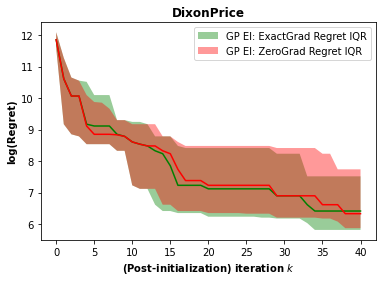

In [118]:
### Visualise!

title = func
plt.figure()

plt.plot(median_exact, color = 'Green')
plt.plot(median_zero, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Green', alpha=0.4, label='GP EI: ExactGrad Regret IQR')
plt.fill_between(xstar, lower_zero, upper_zero, facecolor = 'Red', alpha=0.4, label='GP EI: ZeroGrad Regret IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(0, count, 5))
plt.show() #visualise!


In [119]:
time_exact, time_zero


(5604.744844913483, 536.1557462215424)

In [120]:
np.round(zero_1.acqfunc(Xstar)[0],2).reshape(50,10)


array([[-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.3 , -3468.3 , -3468.3 , -3468.

In [121]:
np.round(exact_1.acqfunc(Xstar)[0],2).reshape(50,10)


array([[-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.31, -3468.31, -3468.31, -3468.31,
        -3468.31, -3468.31, -3468.31, -3468.31],
       [-3468.31, -3468.31, -3468.3 , -3468.3 , -3468.3 , -3468.

In [122]:
np.mean(exact_1.acqfunc(Xstar)[0]), np.mean(zero_1.acqfunc(Xstar)[0])


(-3466.7334599893884, -3181.505857490196)

In [123]:
exact_1.acqfunc(Xstar)[1].shape, zero_1.acqfunc(Xstar)[1].shape


((500, 4), (500, 4))

In [124]:
np.round(exact_1.acqfunc(Xstar)[1],2)


array([[   -0.  ,    -0.  ,    -0.  ,    -0.  ],
       [   -0.  ,    -0.  ,    -0.  ,    -0.  ],
       [   -0.  ,    -0.  ,    -0.  ,    -0.  ],
       ...,
       [-1229.71, -1229.71, -1229.71, -1229.71],
       [-1105.26, -1105.26, -1105.26, -1105.26],
       [ -987.39,  -987.39,  -987.39,  -987.39]])

In [125]:
np.mean(exact_1.acqfunc(Xstar)[1])


-195.5621820961927